# Gait Monitoring for Parkinson's Disease Patients
**Mentor**: Arthur Tay

## Project Description
The objective of this project is to monitor the gait patterns for people with Parkinson Disease. We will analyse the gait for PD patients during freezing and non-freezing (normal) events. Various parameters (e.g. cadence, step lengths, stride lengths, etc) related to gait will be derived from motion sensors (accelerometers, gyroscopes, magnetometers) using public datasets of PD patients. We will then investigate which of these parameters is most suitable for classification for freezing of gait in PD patients.

## Final Product
To make use of signal processing algorithms in extracting gait parameters from motion sensors and identifying most suitable parameters for classification of freezing of gait in PD patients.

## Methodology
Students will first need to review and understands how to extract gait parameters from motion sensors. There are different algorithms in the literature and they will need to investigate which is most suitable. They will then make use of a PD patient public dataset to test out their methods. If time permits, they will learn basic machine learning tools for classification.

## [Daphnet Dataset](https://archive.ics.uci.edu/ml/datasets/Daphnet+Freezing+of+Gait#:~:text=Data%20Set%20Information%3A,on%20generating%20many%20freeze%20events.)
(suggested by Prof Tay)

### Data Description

The Daphnet Freezing of Gait Dataset Freezing of Gait in users with Parkinson disease (hereafter Daphnet Freezing of Gait Dataset) is a dataset devised to benchmark automatic methods to recognize gait freeze from wearable acceleration sensors placed on legs and hip.

The dataset was recorded in the lab with emphasis on generating many freeze events. Users performed there kinds of tasks: straight line walking, walking with numerous turns, and finally a more realistic activity of daily living (ADL) task, where users went into different rooms while fetching coffee, opening doors, etc.

This dataset is the result of a collaboration between the Laboratory for Gait and Neurodynamics, Tel Aviv Sourasky Medical Center, Israel and the Wearable Computing Laboratory, ETH Zurich, Switzerland. Recordings were run at the Tel Aviv Sourasky Medical Center in 2008. The study was approved by the local Human Subjects Review Committee, and was performed in accordance with the ethical standards of the Declaration of Helsinki.

This dataset was collected as part of the EU FP6 project Daphnet, grant number 018474-2.
Additional effort to publish this dataset was supported in part by the EU FP7 project CuPiD, grant number 288516.

### Data Attributes
1. Time of sample in millisecond
2. Ankle (shank) acceleration - horizontal forward acceleration (mg)
3. Ankle (shank) acceleration - vertical (mg)
4. Ankle (shank) acceleration - horizontal lateral (mg)
5. Upper leg (thigh) acceleration - horizontal forward acceleration (mg)
6. Upper leg (thigh) acceleration - vertical (mg)
7. Upper leg (thigh) acceleration - horizontal lateral (mg)
8. Trunk acceleration - horizontal forward acceleration (mg)
9. Trunk acceleration - vertical (mg)
10. Trunk acceleration - horizontal lateral (mg)
11. Annotations (see Annotations section)

#### Annotations
The meaning of the annotations are as follows:
0: not part of the experiment. For instance the sensors are installed on the user or the user is performing activities unrelated to the experimental protocol, such as debriefing
1: experiment, no freeze (can be any of stand, walk, turn)
2: freeze

### Set-Up and Imports

In [1]:
%load_ext autoreload
%autoreload 2
# to ensure kernel resets when files change around it

In [2]:
from forest import * # basically lazy imports everything we need to care about
import np # main library for numeric calculations
# import pandas as pd - main library for data analysis
# import matplotlib.pyplot as plt - main library for data plotting
from glob import glob # check files
from math import *
from IPython.display import display, Markdown
# import scipy as sp - STEM software
# from scipy import signal

"""
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)"""

warnings.filterwarnings('ignore') # literally to ignore all the warnings that don't matter

In [3]:
# Enabling the `widget` backend.
# This requires jupyter-matplotlib a.k.a. ipympl.
# ipympl can be install via pip or conda.
%matplotlib widget

# Testing matplotlib interactions with a simple plot
fig = plt.figure()
fig.canvas.header_visible = False # Hide the Figure name at the top of the figure
fig.canvas.toolbar_visible = True

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Get Data

In [3]:
#daphnet = []
daphnetThigh = []
daphnetNames = []
for i in sorted(glob("daphnet/S*.txt")):
    daphnetNames.append(i.split("\\")[-1])
    csv = pd.read_csv(i, sep=" ", names=["time", "shank_h_fd", "shank_v", "shank_h_l", "thigh_h_fd", "thigh_v", "thigh_h_l", "trunk_h_fd", "trunk_v", "trunk_h_l", "annotations"])[["time", "thigh_h_fd", "thigh_v", "thigh_h_l", "annotations"]].set_index("time")
    csv["thigh"] = np.sqrt(csv["thigh_h_l"]**2 + csv["thigh_v"]**2 + csv["thigh_h_fd"]**2)
    csv = csv[["thigh_h_fd", "thigh_v", "thigh_h_l", "thigh", "annotations"]]
    #daphnet.append(pd.read_csv(i, sep=" ", names=["time", "shank_h_fd", "shank_v", "shank_h_l", "thigh_h_fd", "thigh_v", "thigh_h_l", "trunk_h_fd", "trunk_v", "trunk_h_l", "annotations"]))
    daphnetThigh.append(csv)

daphnetThigh[0]

thigh_h_fd  thigh_v  thigh_h_l        thigh  annotations
time                                                             
15                0        0          0     0.000000            0
31                0        0          0     0.000000            0
46                0        0          0     0.000000            0
62                0        0          0     0.000000            0
78                0        0          0     0.000000            0
...             ...      ...        ...          ...          ...
2374734           9      -46      -1000  1001.097897            0
2374750          -9      -27       -979   979.413600            0
2374765         -18      -37       -979   979.864276            0
2374781           9      -46       -969   970.132981            0
2374796           0        0          0     0.000000            0

[151987 rows x 5 columns]

### Plots

S01R01.txt


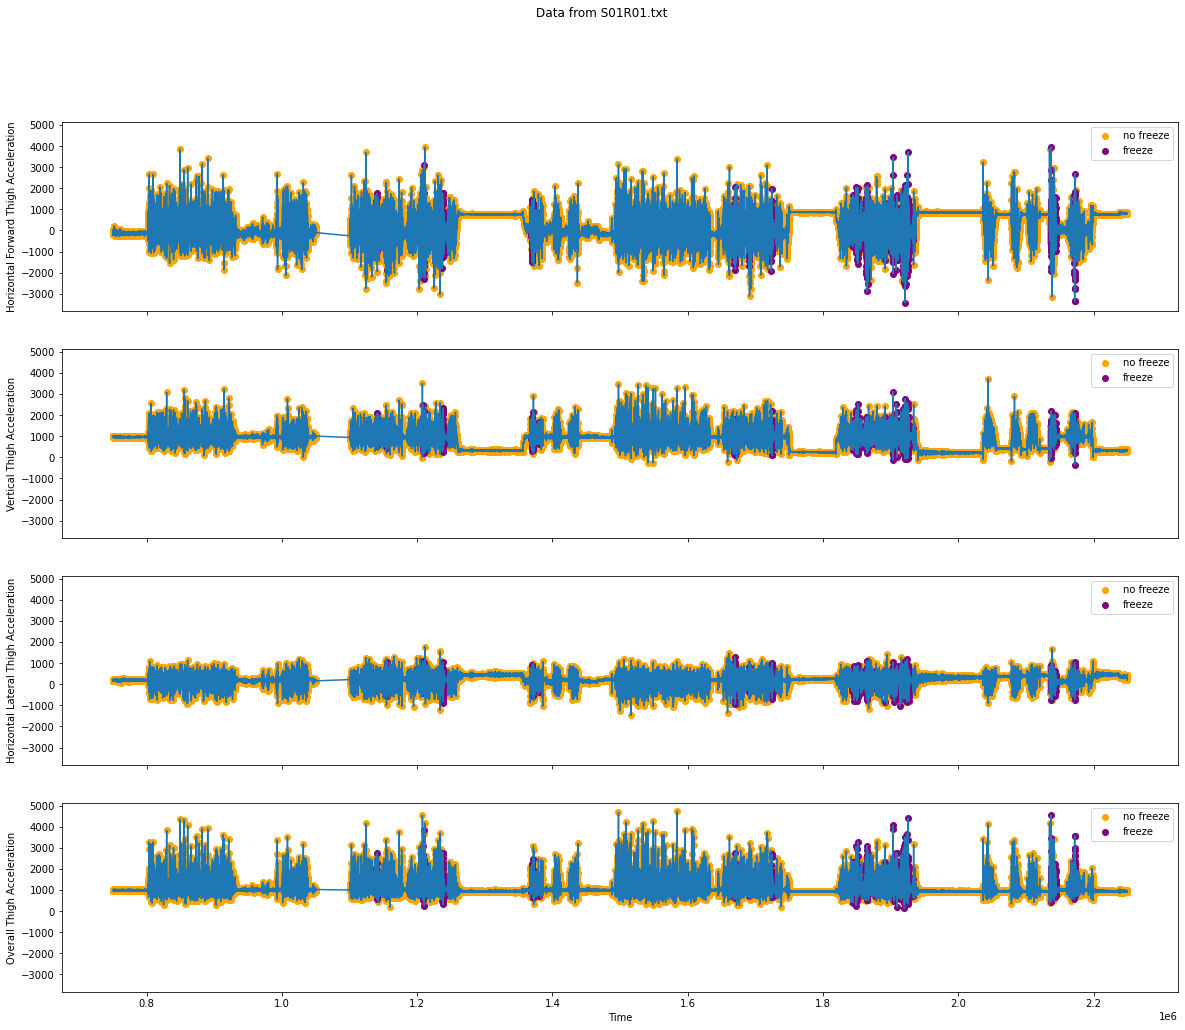

S01R02.txt


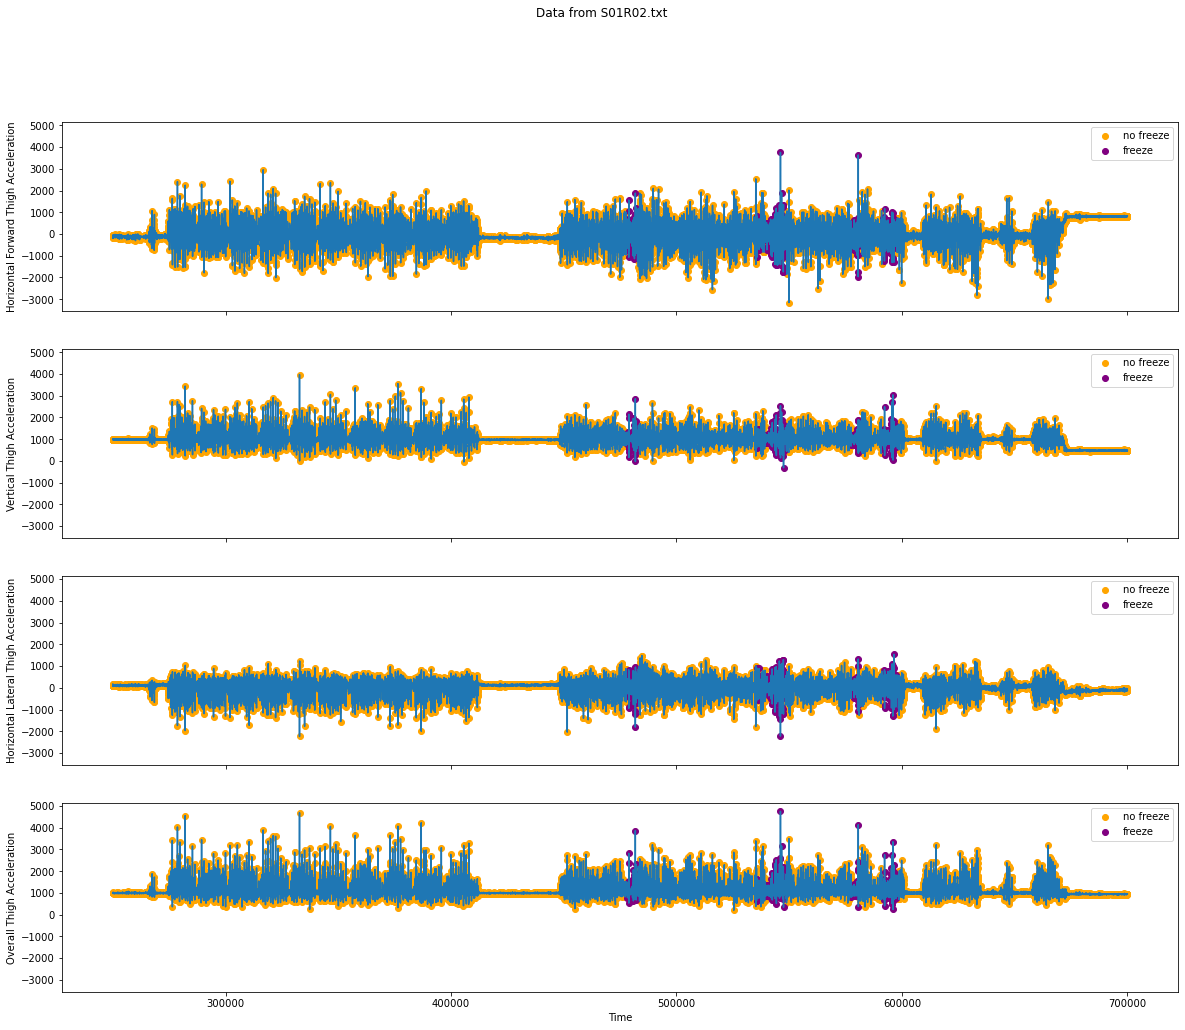

S02R01.txt


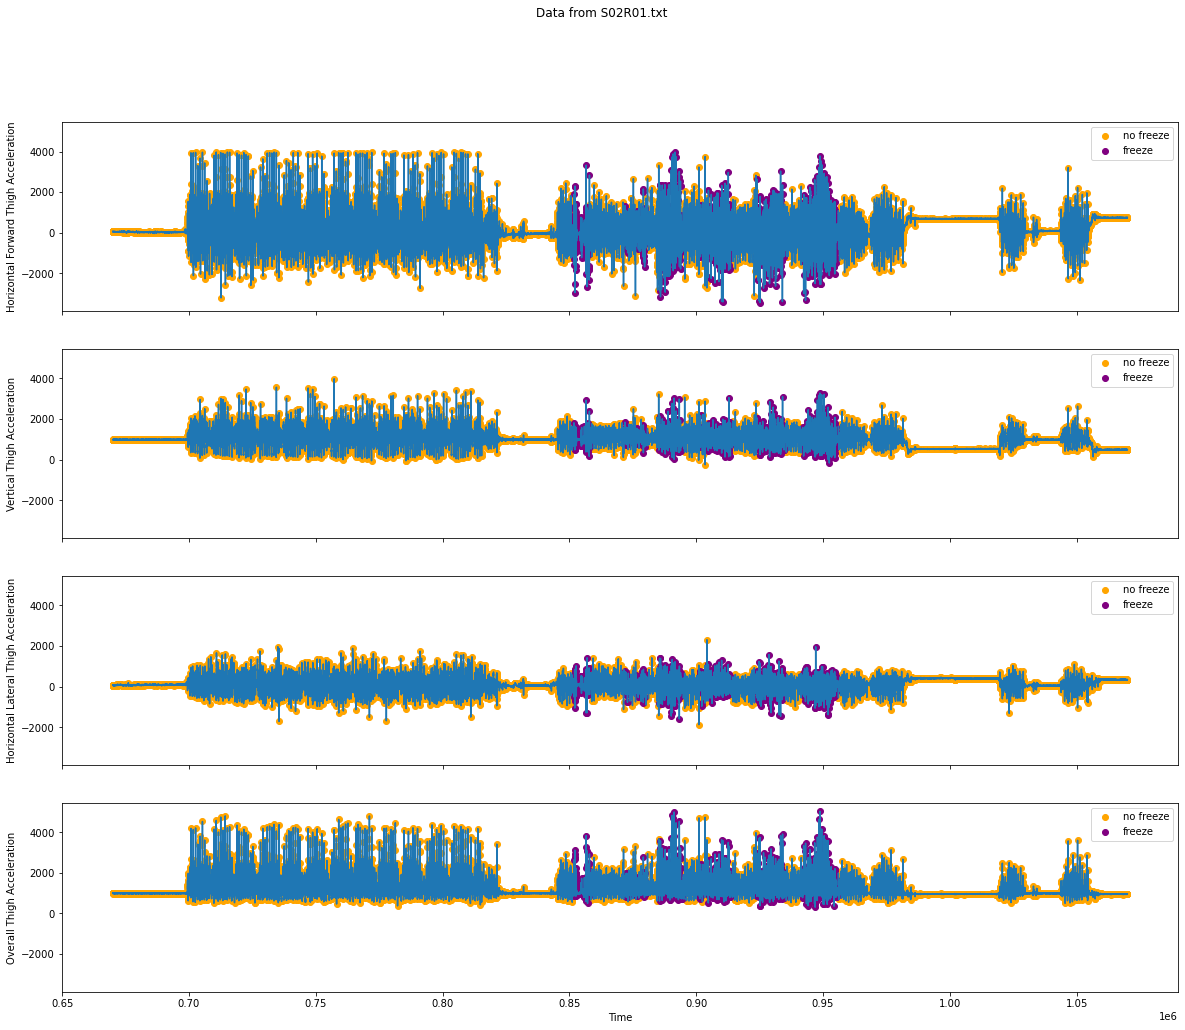

S02R02.txt


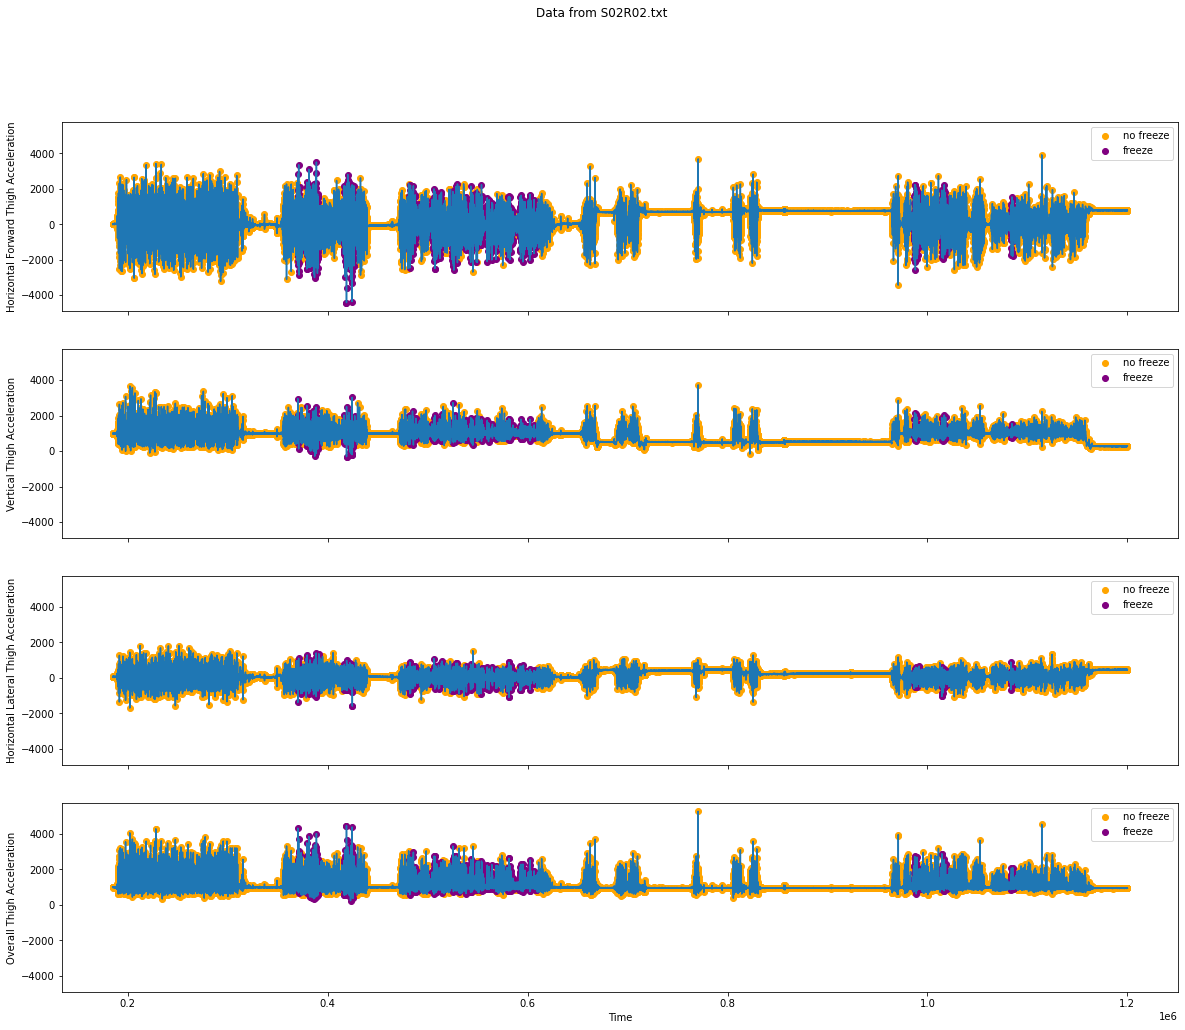

S03R01.txt


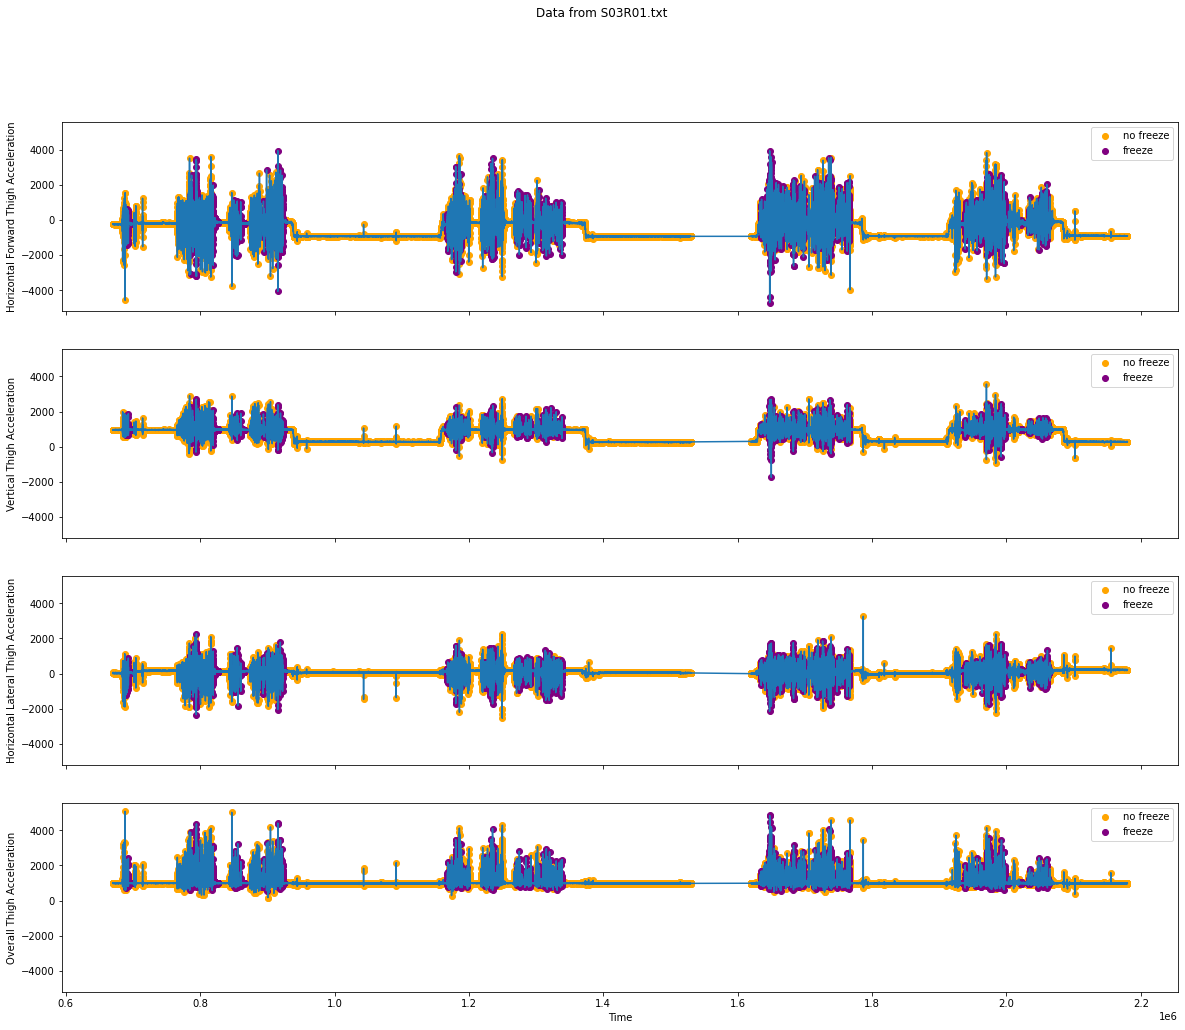

S03R02.txt


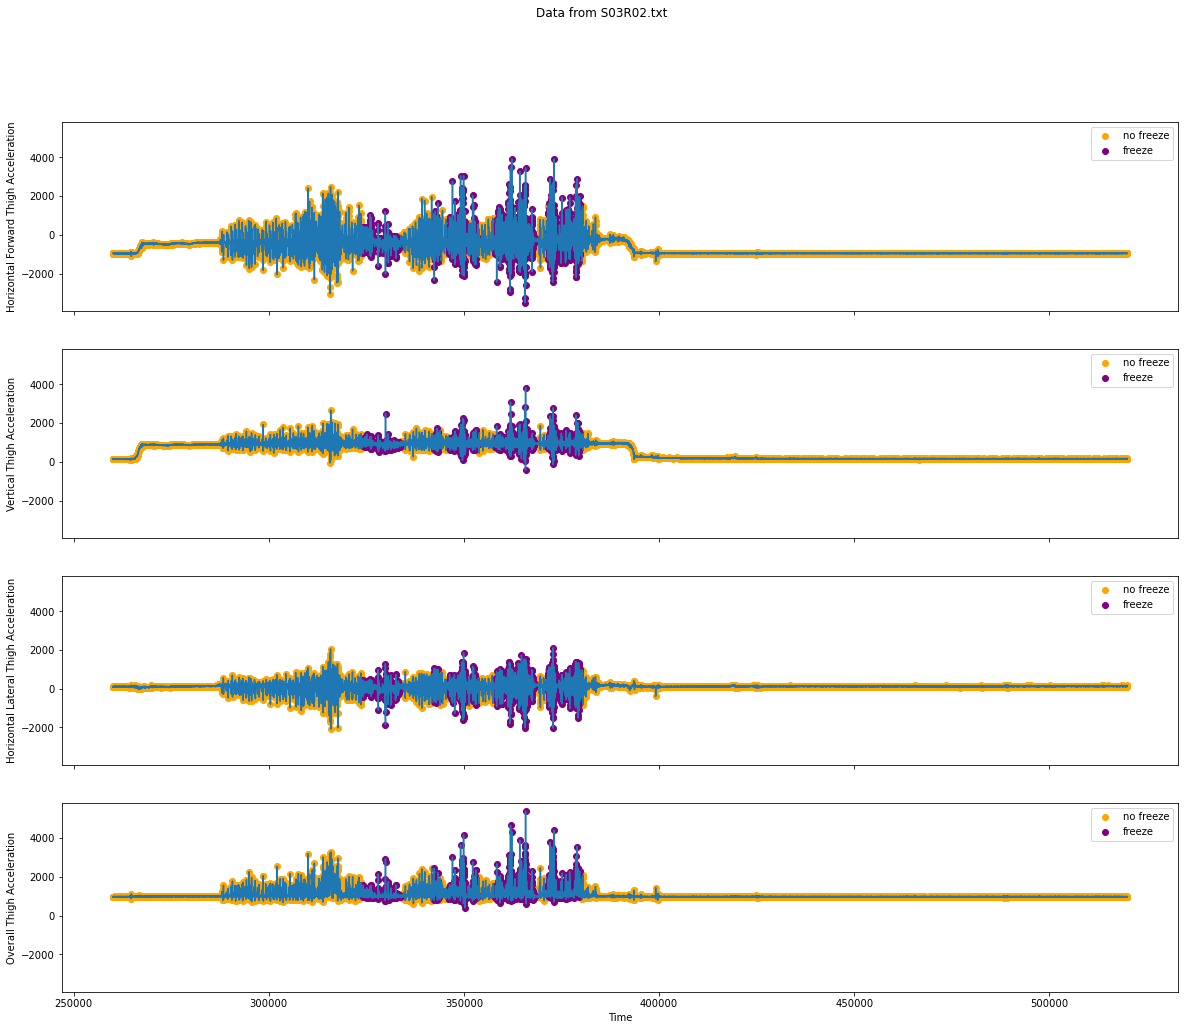

S03R03.txt


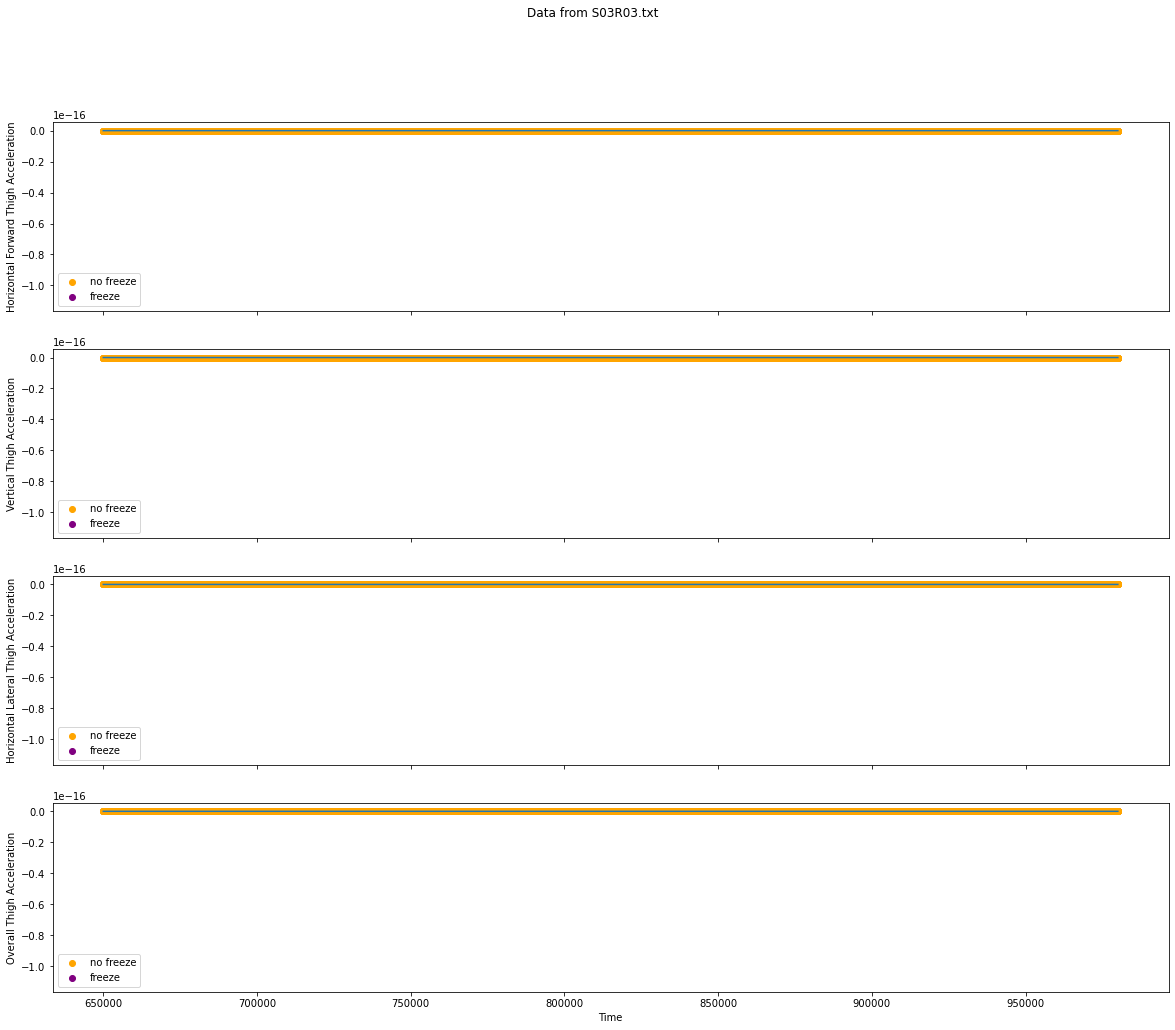

S04R01.txt


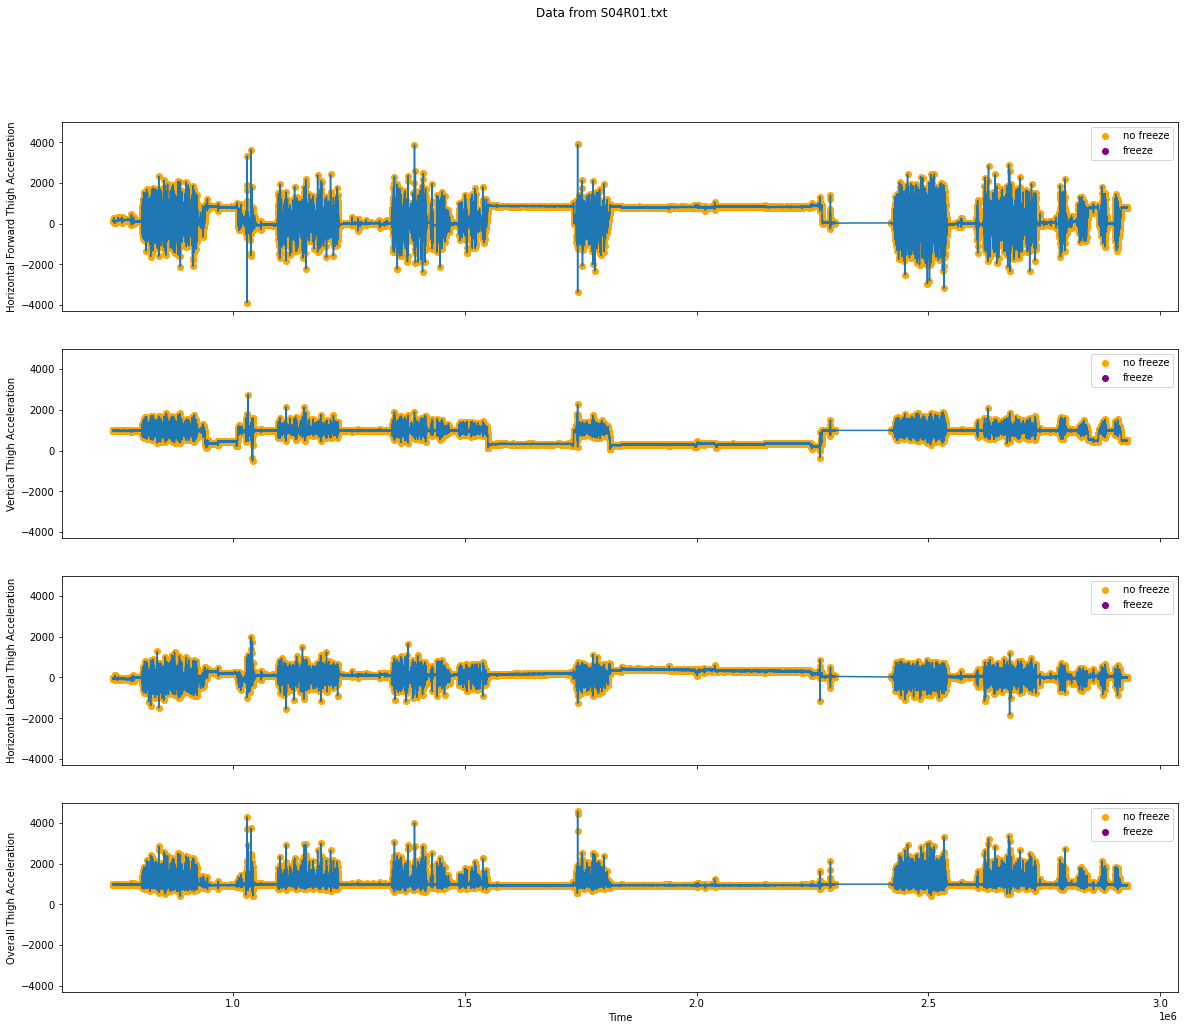

S05R01.txt


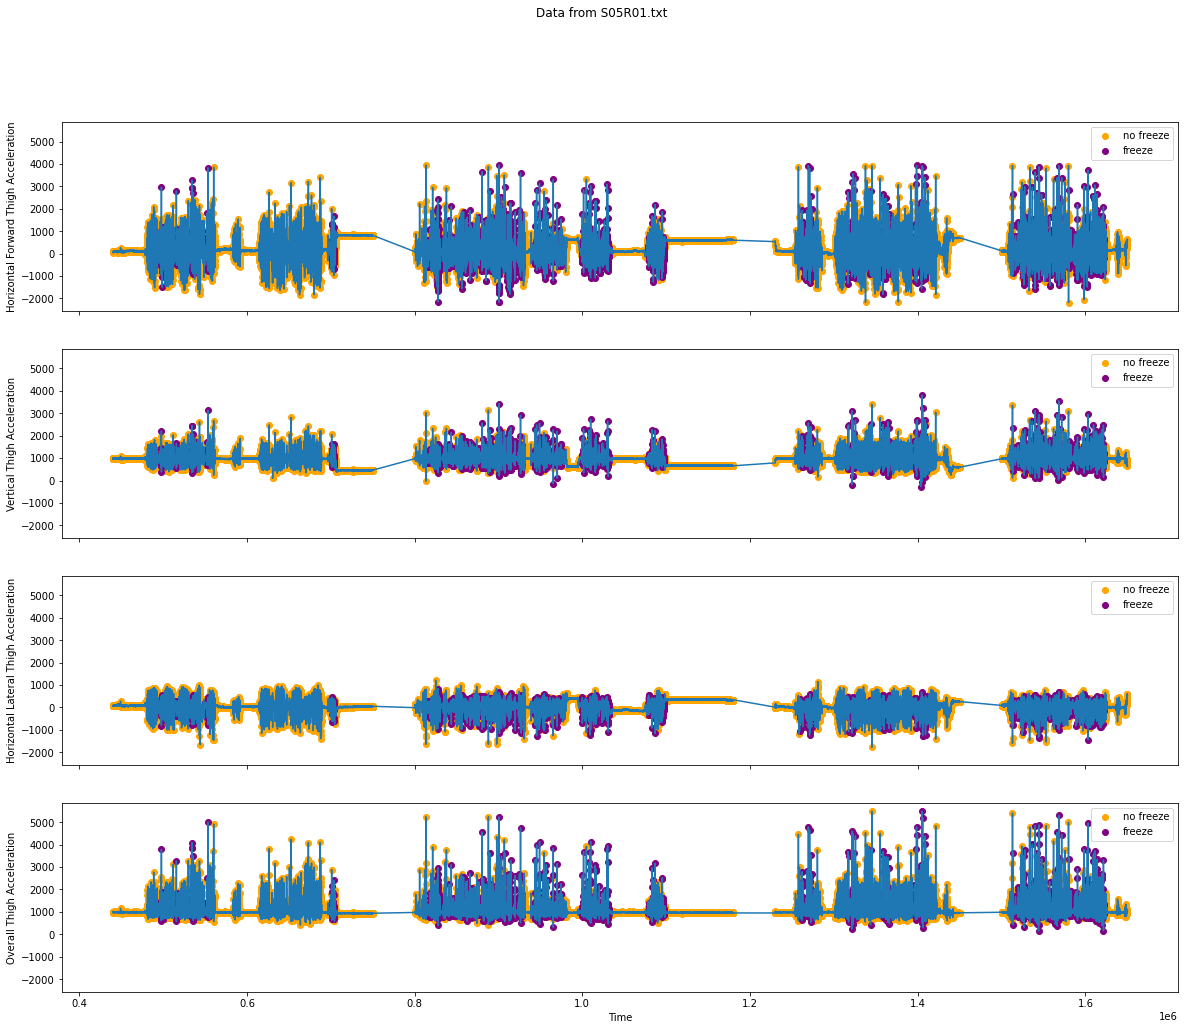

S05R02.txt


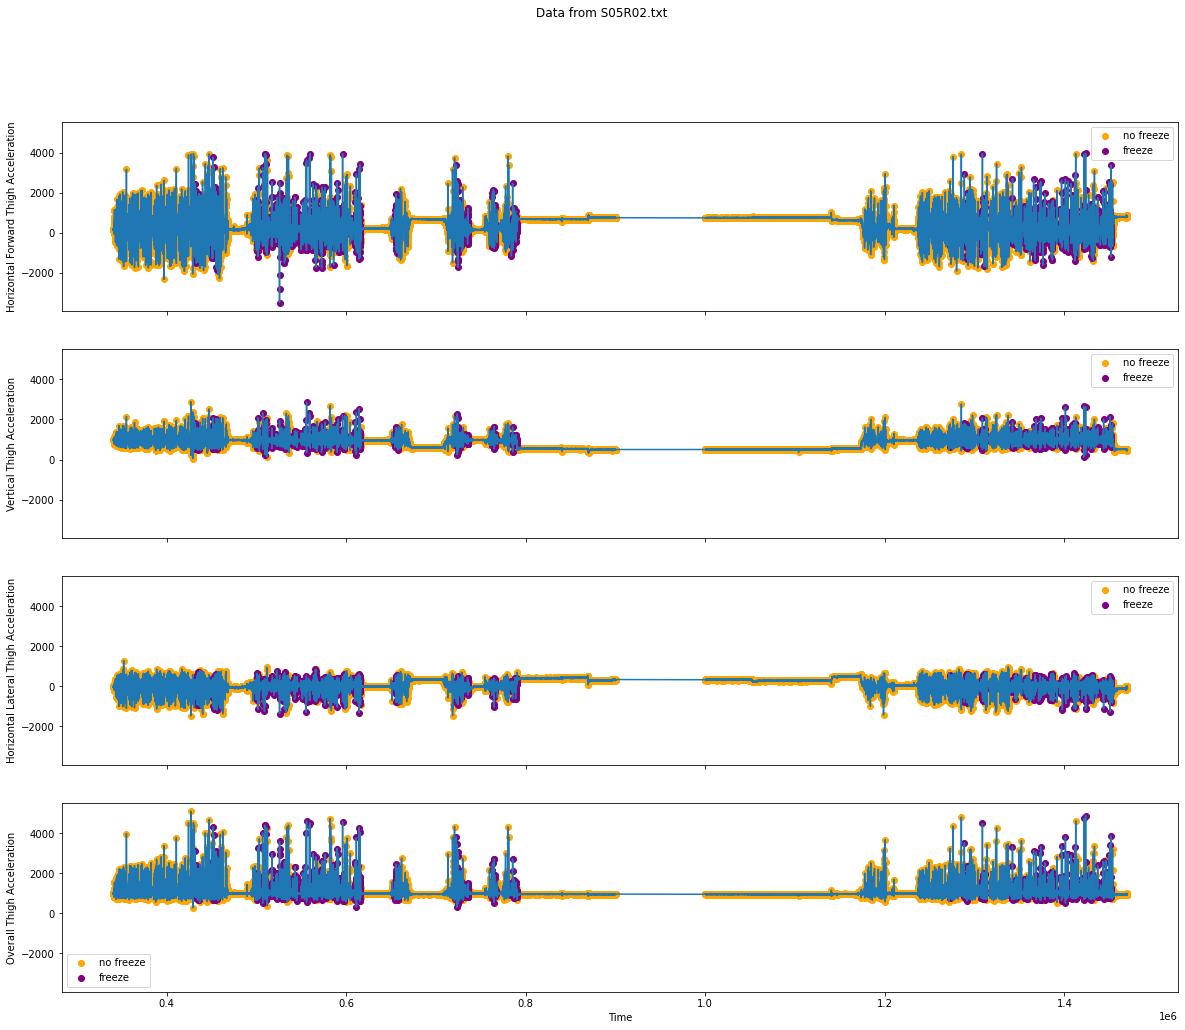

S06R01.txt


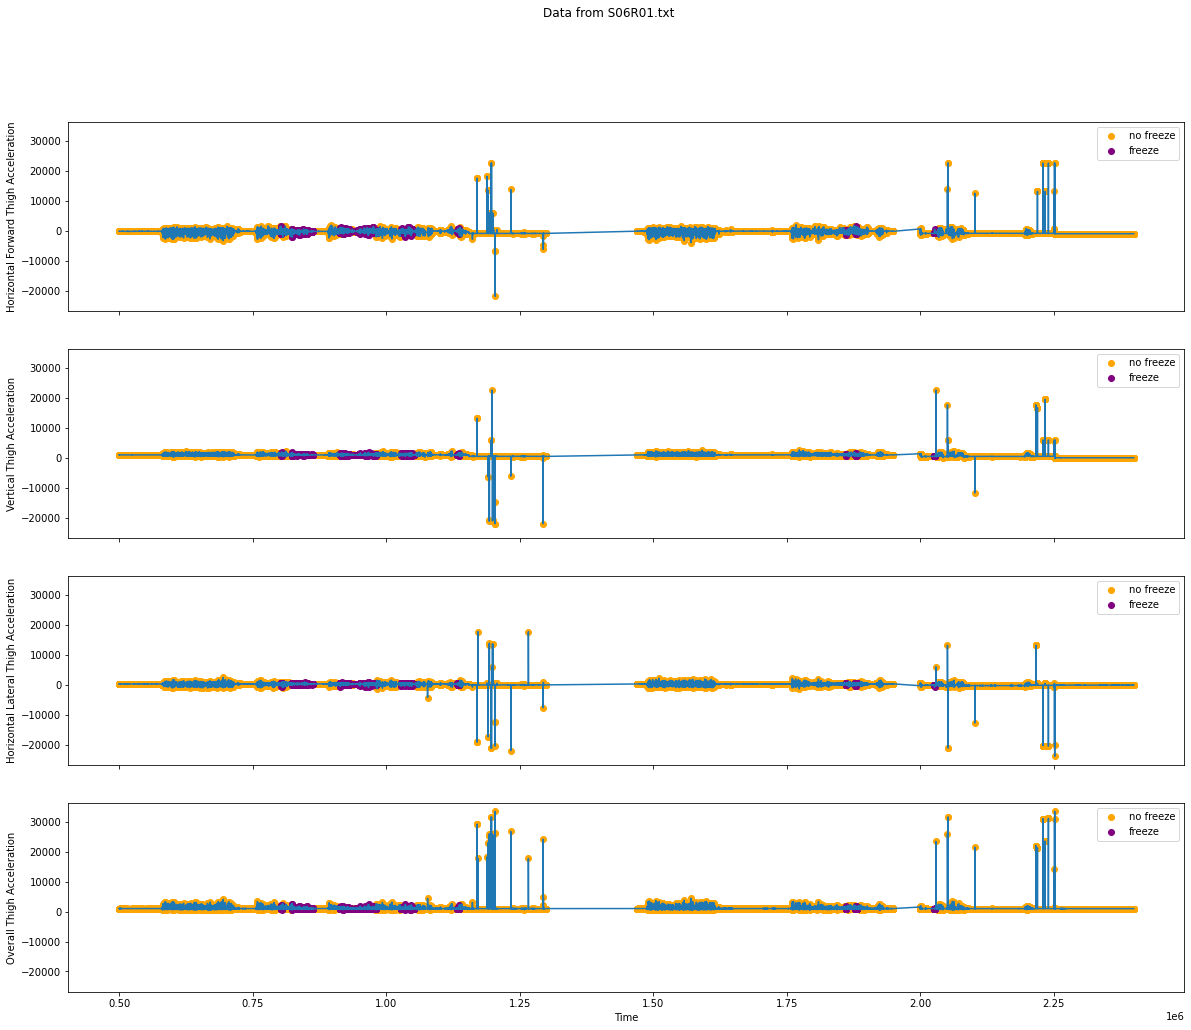

S06R02.txt


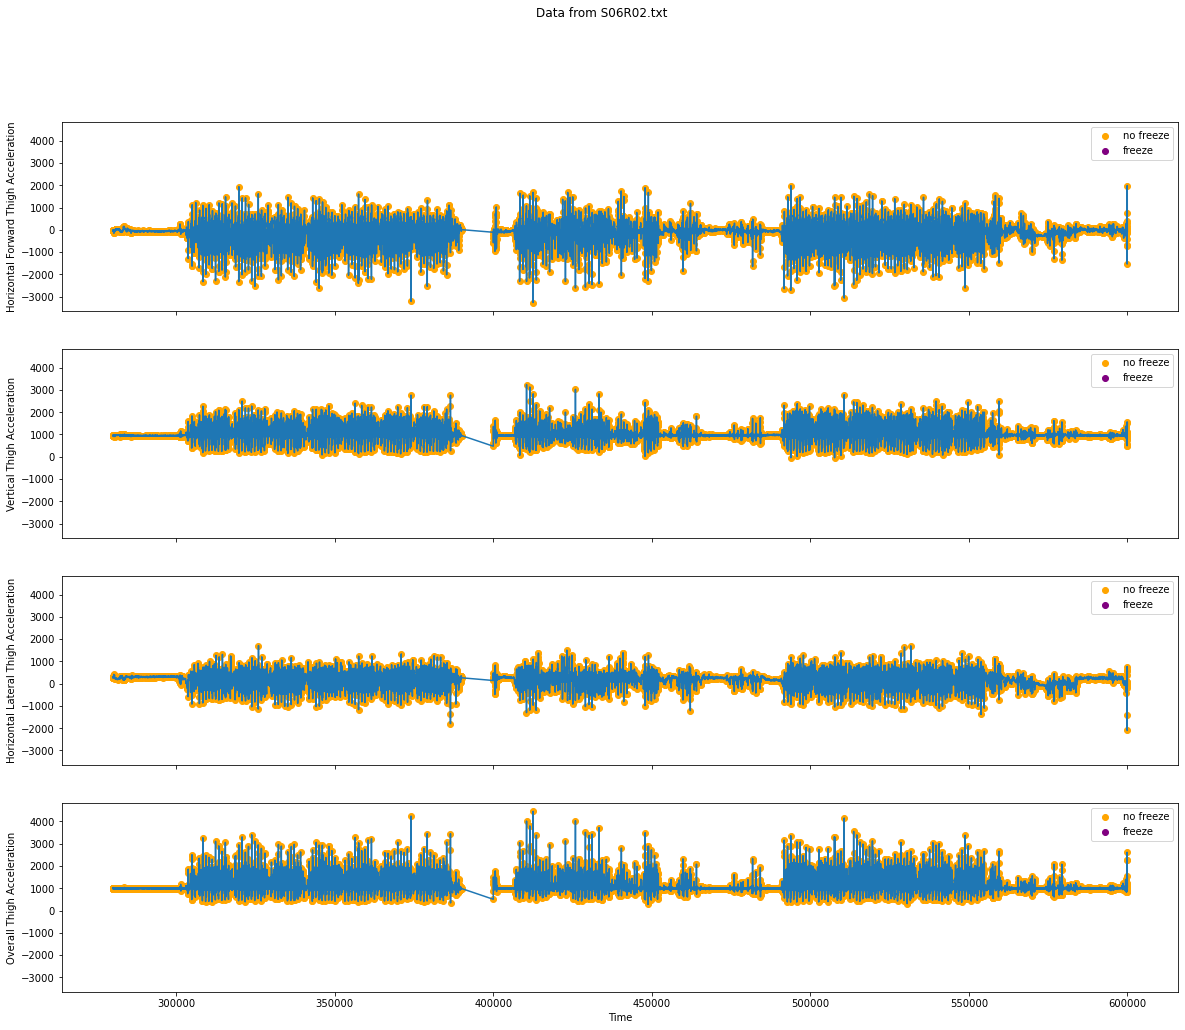

S07R01.txt


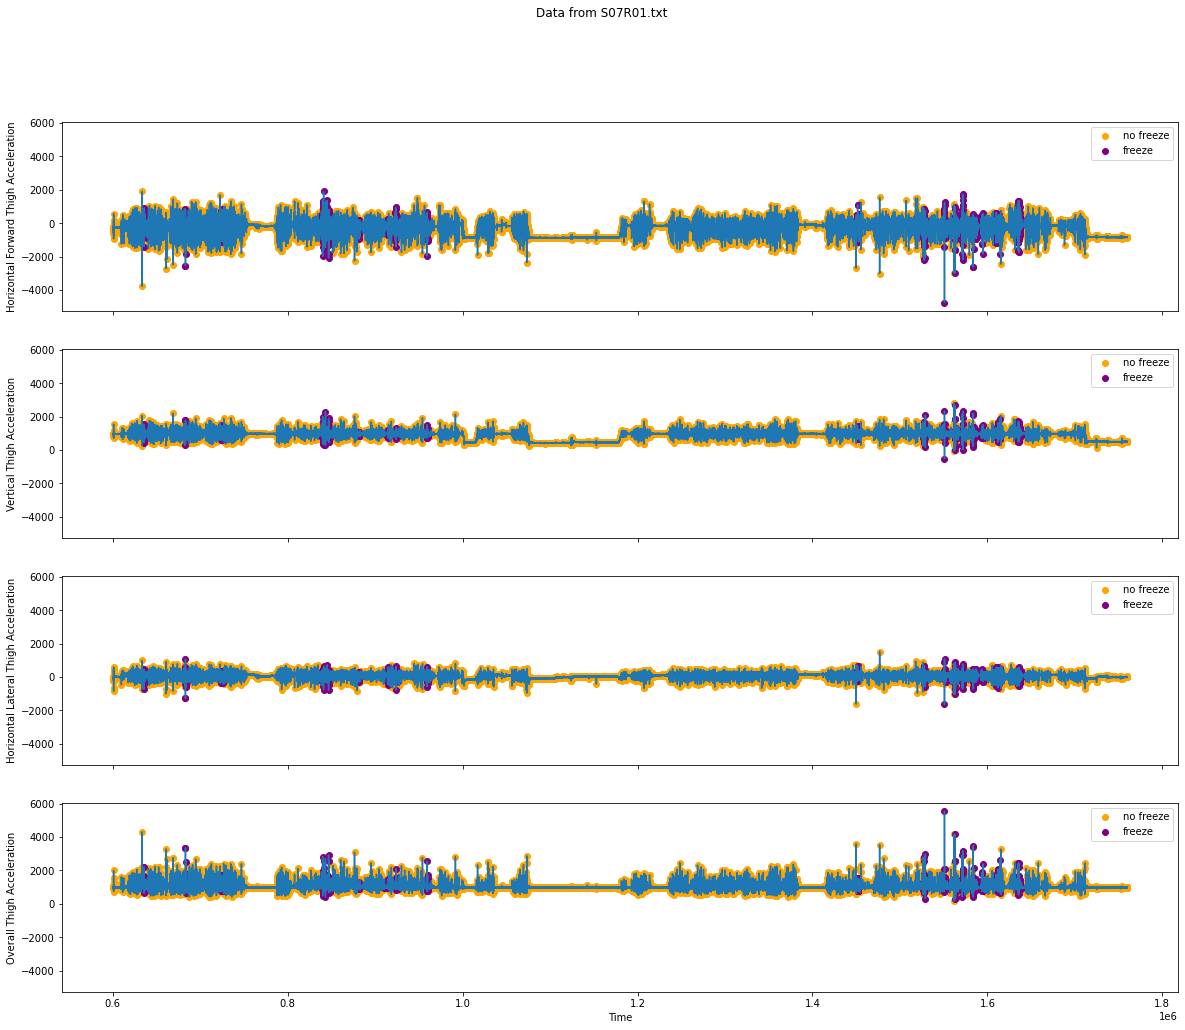

S07R02.txt


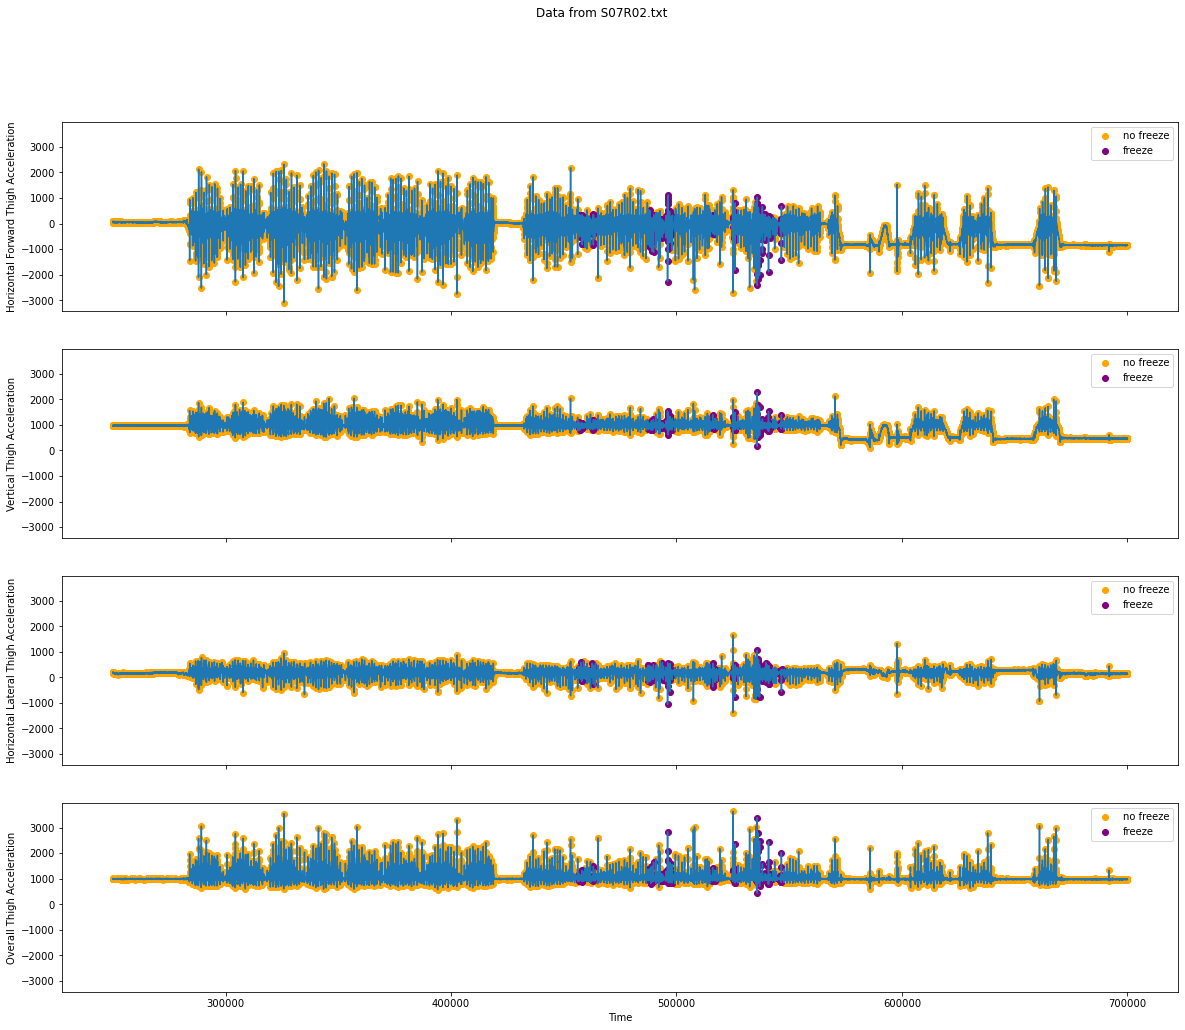

S08R01.txt


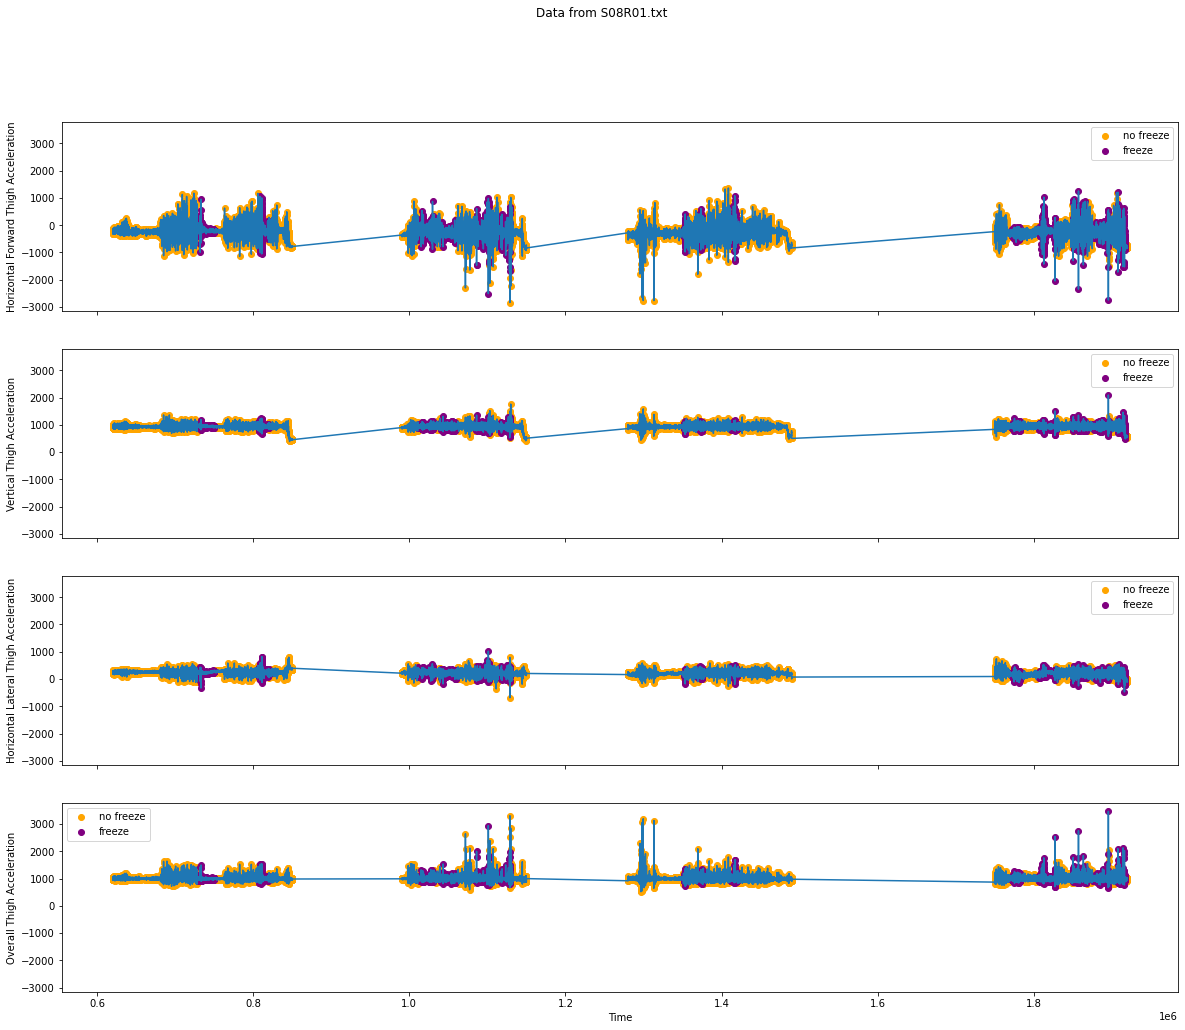

S09R01.txt


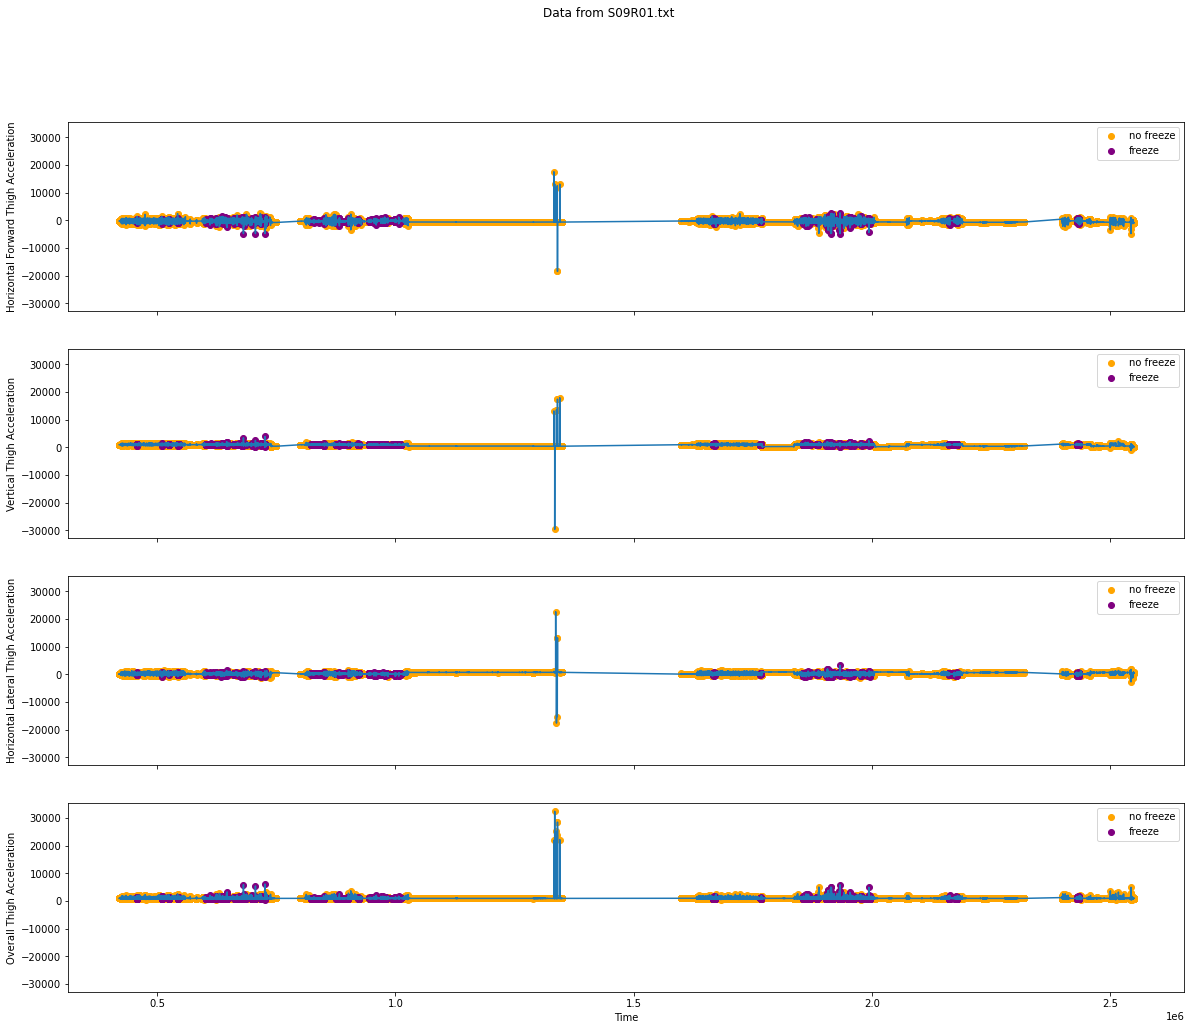

S10R01.txt


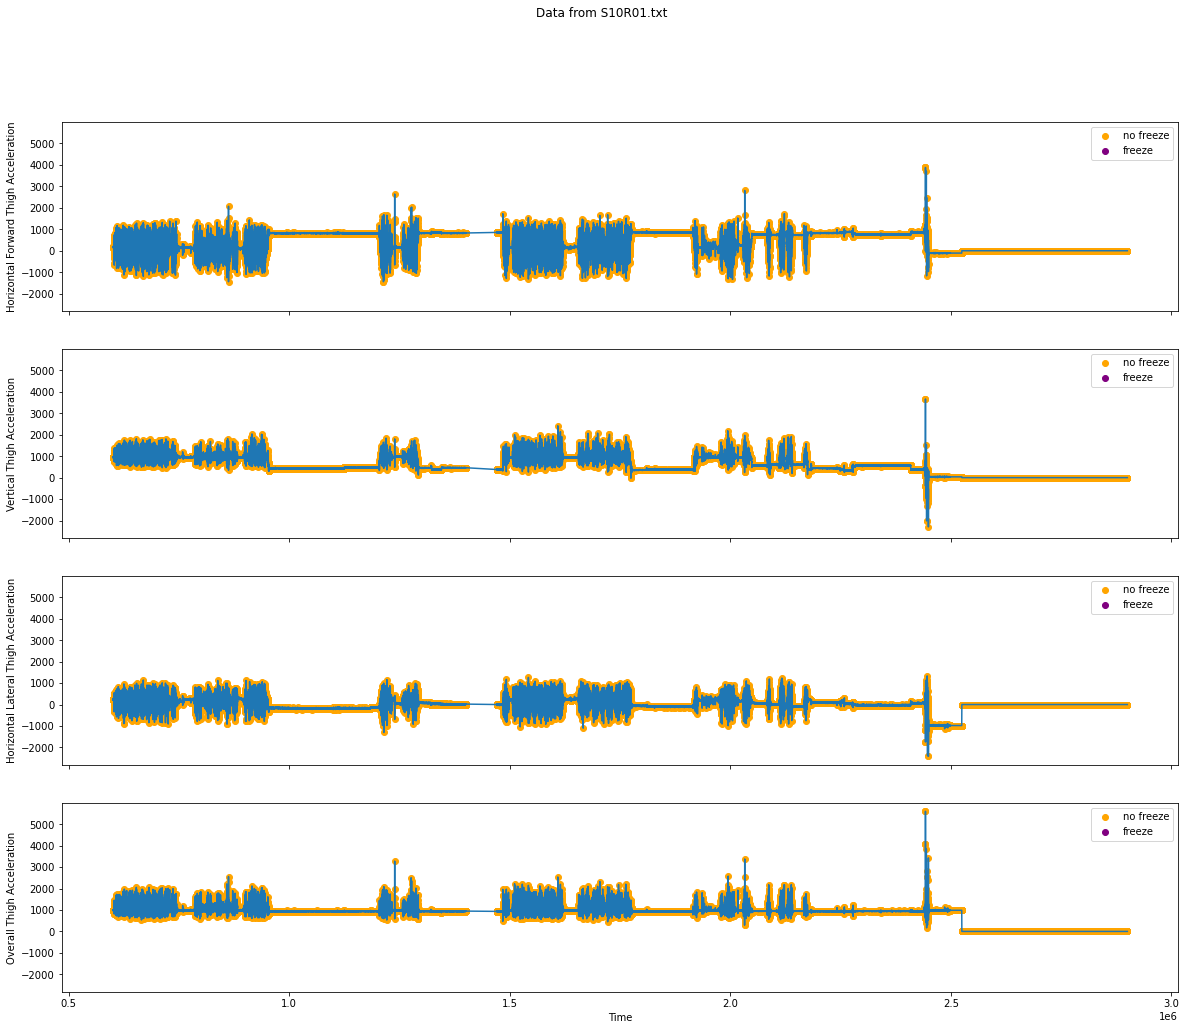

In [4]:
for i in range(len(daphnetThigh)):
    print(daphnetNames[i])
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=True, figsize=(20, 16))
    fig.suptitle("Data from "+daphnetNames[i])
    plt.xlabel("Time")
    
    df = daphnetThigh[i]
    df = df[df.annotations > 0]
    neg = df[df.annotations == 1]
    pos = df[df.annotations == 2]
    
    ax1 = axes[0]
    ax1.plot(df.thigh_h_fd)
    ax1.set_ylabel("Horizontal Forward Thigh Acceleration")
    ax1.scatter(neg.index, neg.thigh_h_fd, c='orange', label="no freeze")
    ax1.scatter(pos.index, pos.thigh_h_fd, c='purple', label="freeze")
    ax1.legend()
    
    ax2 = axes[1]
    ax2.plot(df.thigh_v)
    ax2.set_ylabel("Vertical Thigh Acceleration")
    ax2.scatter(neg.index, neg.thigh_v, c='orange', label="no freeze")
    ax2.scatter(pos.index, pos.thigh_v, c='purple', label="freeze")
    ax2.legend()
    
    ax3 = axes[2]
    ax3.plot(df.thigh_h_l)
    ax3.set_ylabel("Horizontal Lateral Thigh Acceleration")
    ax3.scatter(neg.index, neg.thigh_h_l, c='orange', label="no freeze")
    ax3.scatter(pos.index, pos.thigh_h_l, c='purple', label="freeze")
    ax3.legend()
    
    ax4 = axes[3]
    ax4.plot(df.thigh)
    ax4.set_ylabel("Overall Thigh Acceleration")
    ax4.scatter(neg.index, neg.thigh, c='orange', label="no freeze")
    ax4.scatter(pos.index, pos.thigh, c='purple', label="freeze")
    ax4.legend()
    
    plt.show()

### Signal Processing Algorithm
Motive: get postulated freeze index in a window of 256 datapoints.


#### Subject Identification and Analysis
using OOP

In [5]:
from scripts.daphnet import Subject
subjects = Subject.parse(daphnetThigh, daphnetNames)
subjects

[01 2, 02 2, 03 3, 04 1, 05 2, 06 2, 07 2, 08 1, 09 1, 10 1]

#### Getting Hypothesis

In [6]:
hdaphnet = [subject.analyze() for subject in subjects]
hdaphnet

[[[array([0., 0., 0., ..., 0., 0., 0.]),
   array([0.10866475, 0.11041725, 0.11198042, ..., 0.        , 0.        ,
          0.        ]),
   array([0.10867678, 0.11042204, 0.11197194, ..., 0.        , 0.        ,
          0.        ]),
   array([0., 0., 0., ..., 0., 0., 0.])],
  [array([0., 0., 0., ..., 0., 0., 0.]),
   array([0.39558639, 0.29374187, 0.22793243, ..., 0.        , 0.        ,
          0.        ]),
   array([0.39555996, 0.29376659, 0.22795609, ..., 0.        , 0.        ,
          0.        ]),
   array([0., 0., 0., ..., 0., 0., 0.])]],
 [[array([0., 0., 0., ..., 0., 0., 0.]),
   array([0.08447839, 0.08022342, 0.07790598, ..., 0.        , 0.        ,
          0.        ]),
   array([0.08448746, 0.08019283, 0.07785778, ..., 0.        , 0.        ,
          0.        ]),
   array([0., 0., 0., ..., 0., 0., 0.])],
  [array([1.23331793, 0.96611927, 0.72998989, ..., 0.        , 0.        ,
          0.        ]),
   array([0.        , 0.96568739, 0.72896628, ..., 0.    

##### Fix Data

In [7]:
hyp = []
for i in hdaphnet:
    for j in i: 
        hyp.append(j)

hyp

[[array([0., 0., 0., ..., 0., 0., 0.]),
  array([0.10866475, 0.11041725, 0.11198042, ..., 0.        , 0.        ,
         0.        ]),
  array([0.10867678, 0.11042204, 0.11197194, ..., 0.        , 0.        ,
         0.        ]),
  array([0., 0., 0., ..., 0., 0., 0.])],
 [array([0., 0., 0., ..., 0., 0., 0.]),
  array([0.39558639, 0.29374187, 0.22793243, ..., 0.        , 0.        ,
         0.        ]),
  array([0.39555996, 0.29376659, 0.22795609, ..., 0.        , 0.        ,
         0.        ]),
  array([0., 0., 0., ..., 0., 0., 0.])],
 [array([0., 0., 0., ..., 0., 0., 0.]),
  array([0.08447839, 0.08022342, 0.07790598, ..., 0.        , 0.        ,
         0.        ]),
  array([0.08448746, 0.08019283, 0.07785778, ..., 0.        , 0.        ,
         0.        ]),
  array([0., 0., 0., ..., 0., 0., 0.])],
 [array([1.23331793, 0.96611927, 0.72998989, ..., 0.        , 0.        ,
         0.        ]),
  array([0.        , 0.96568739, 0.72896628, ..., 0.        , 0.        ,
    

### Plots

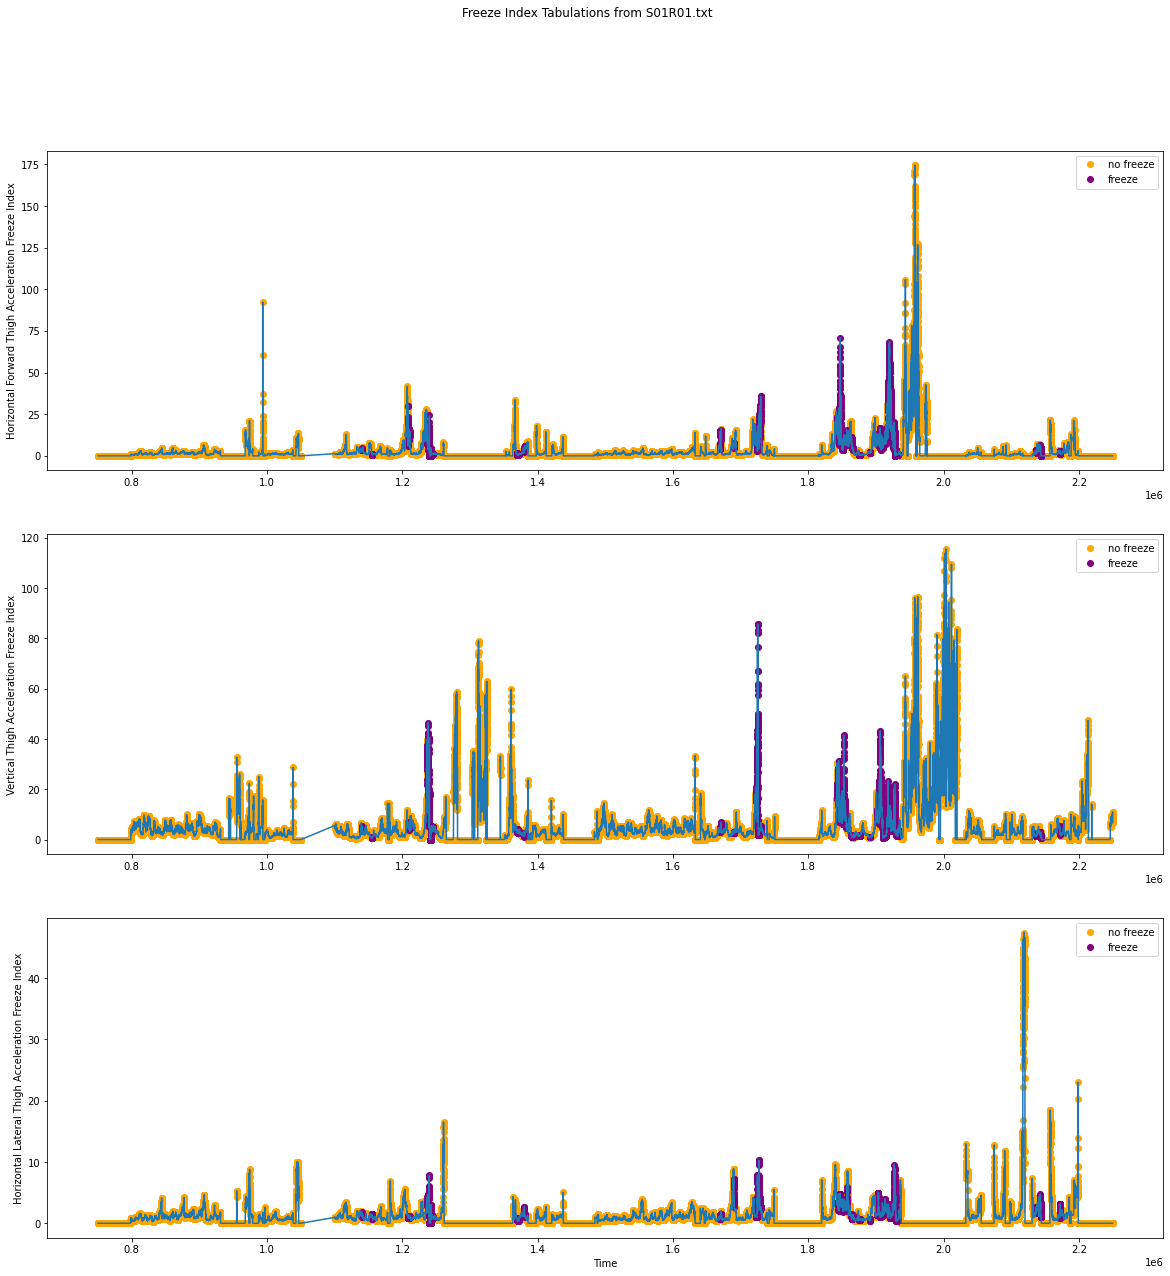

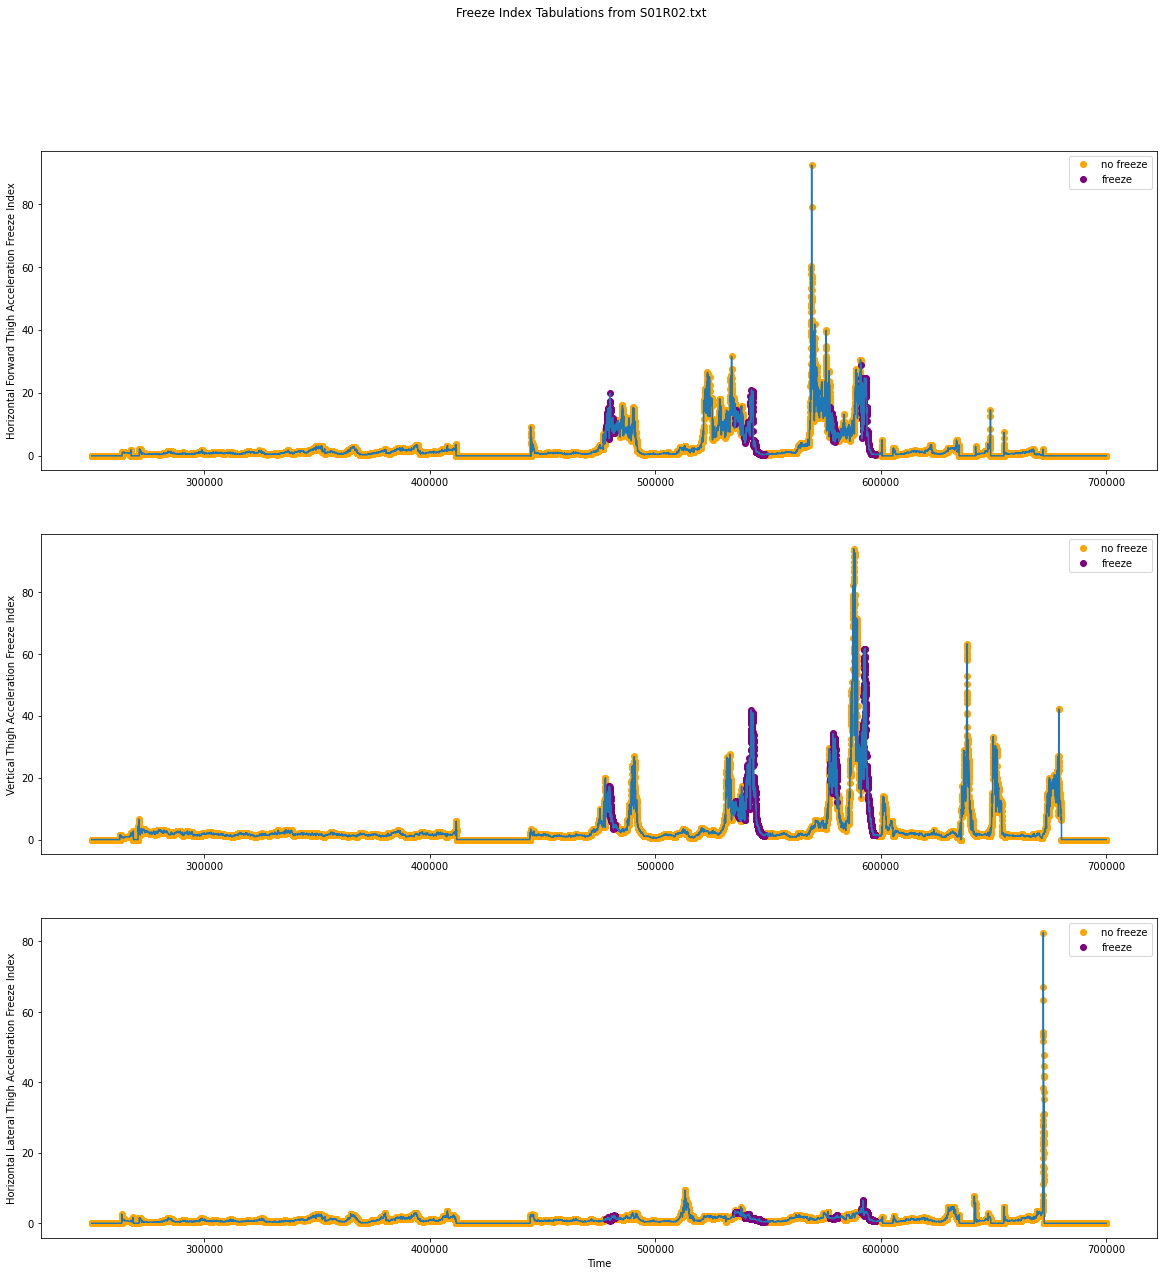

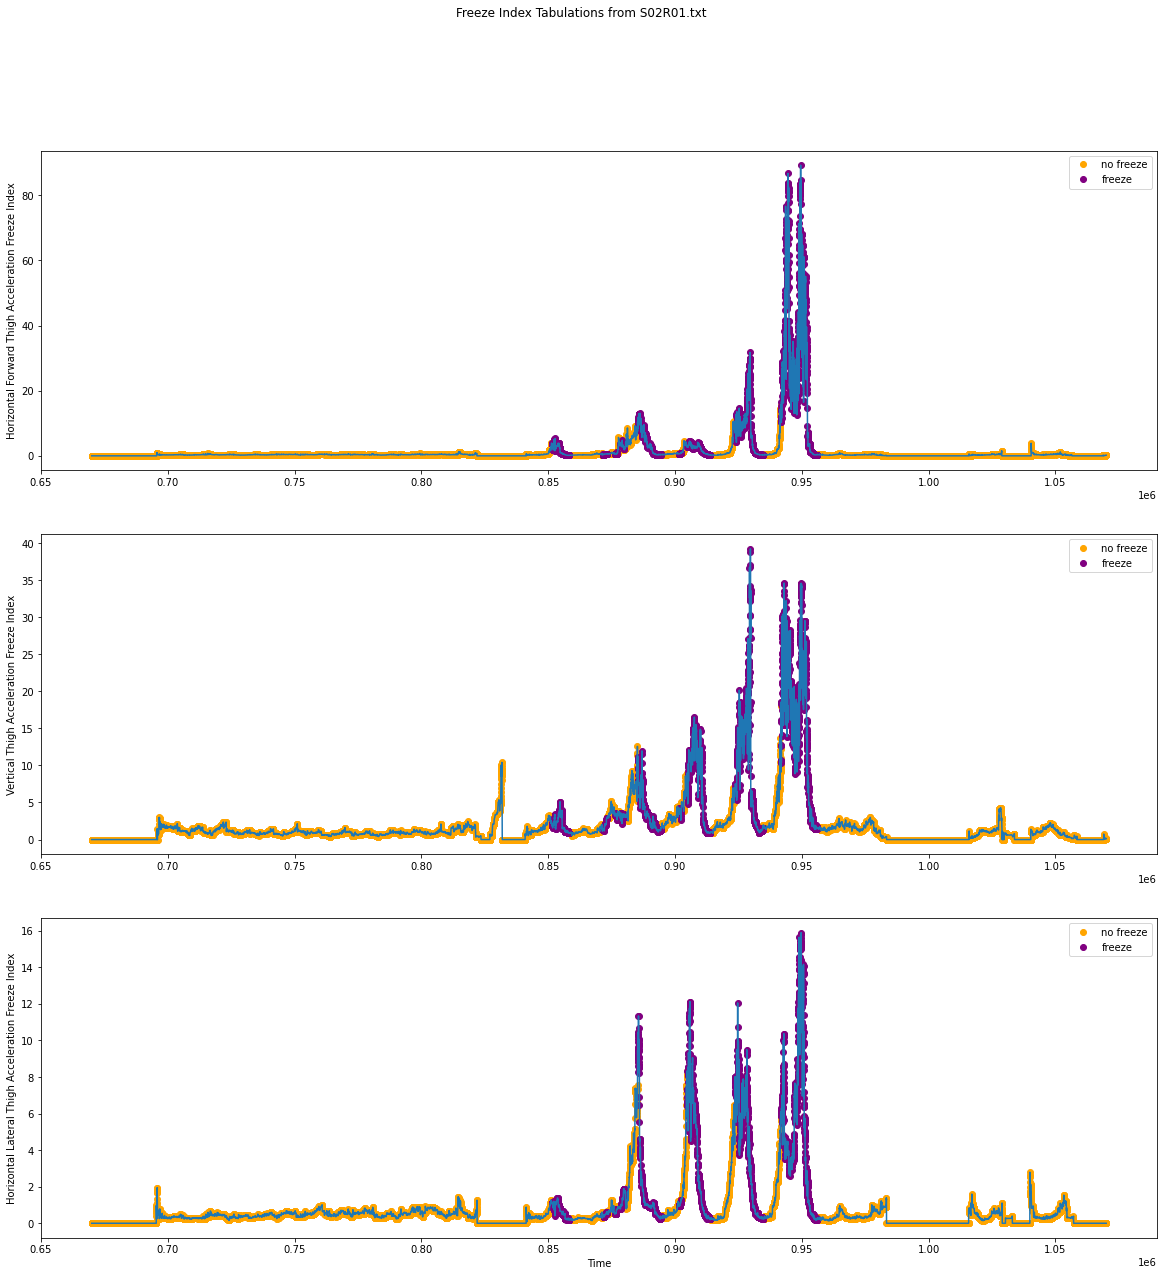

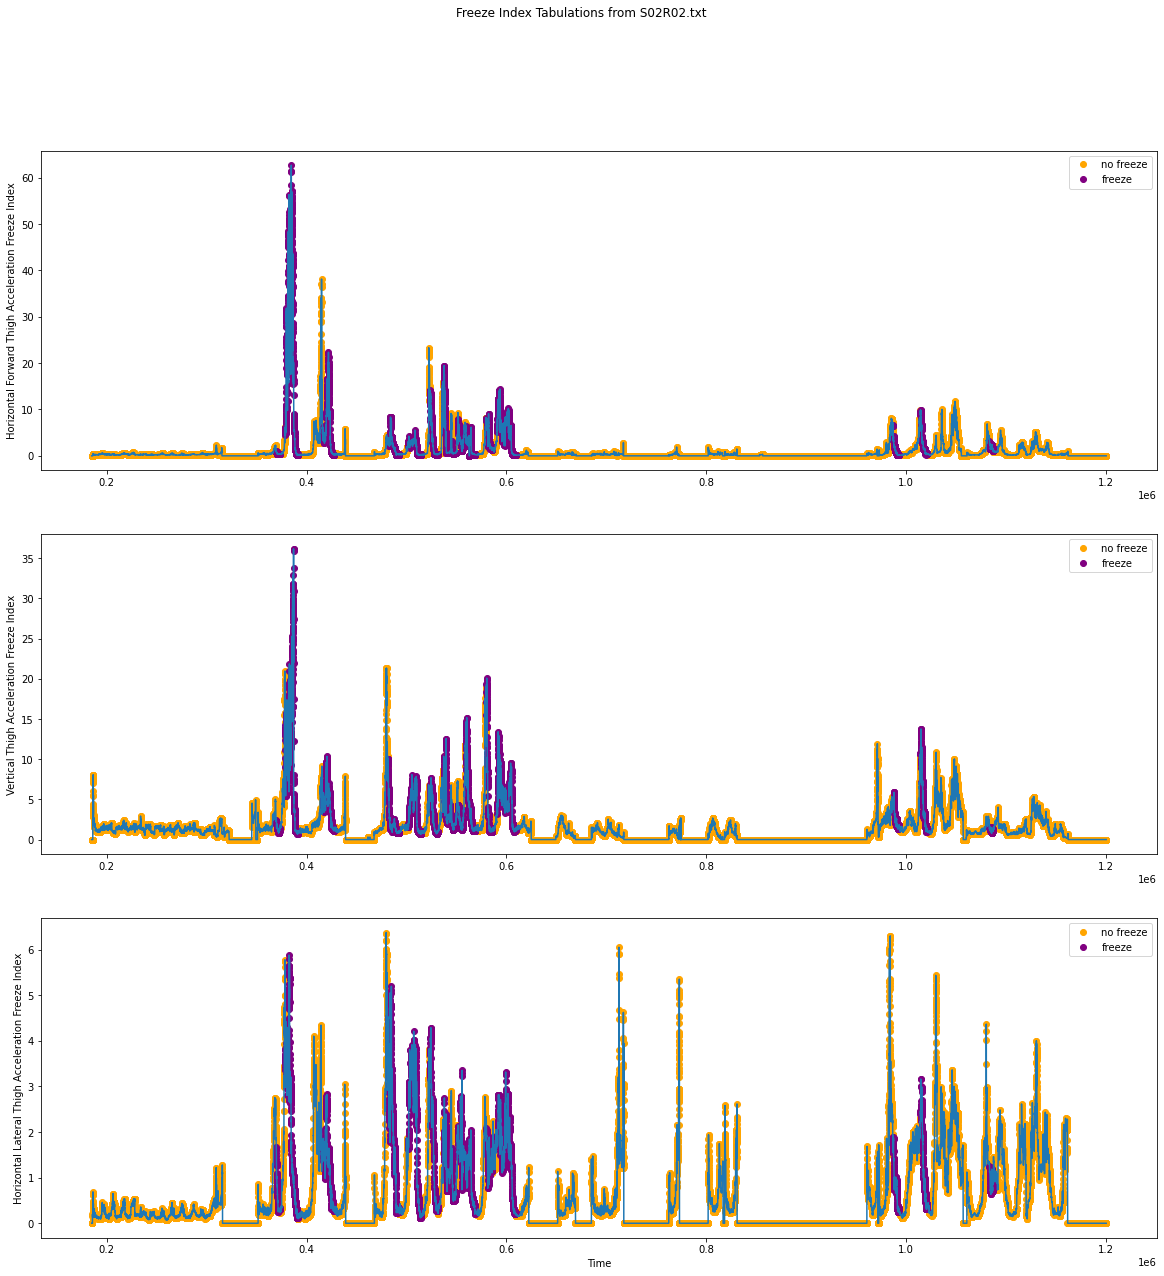

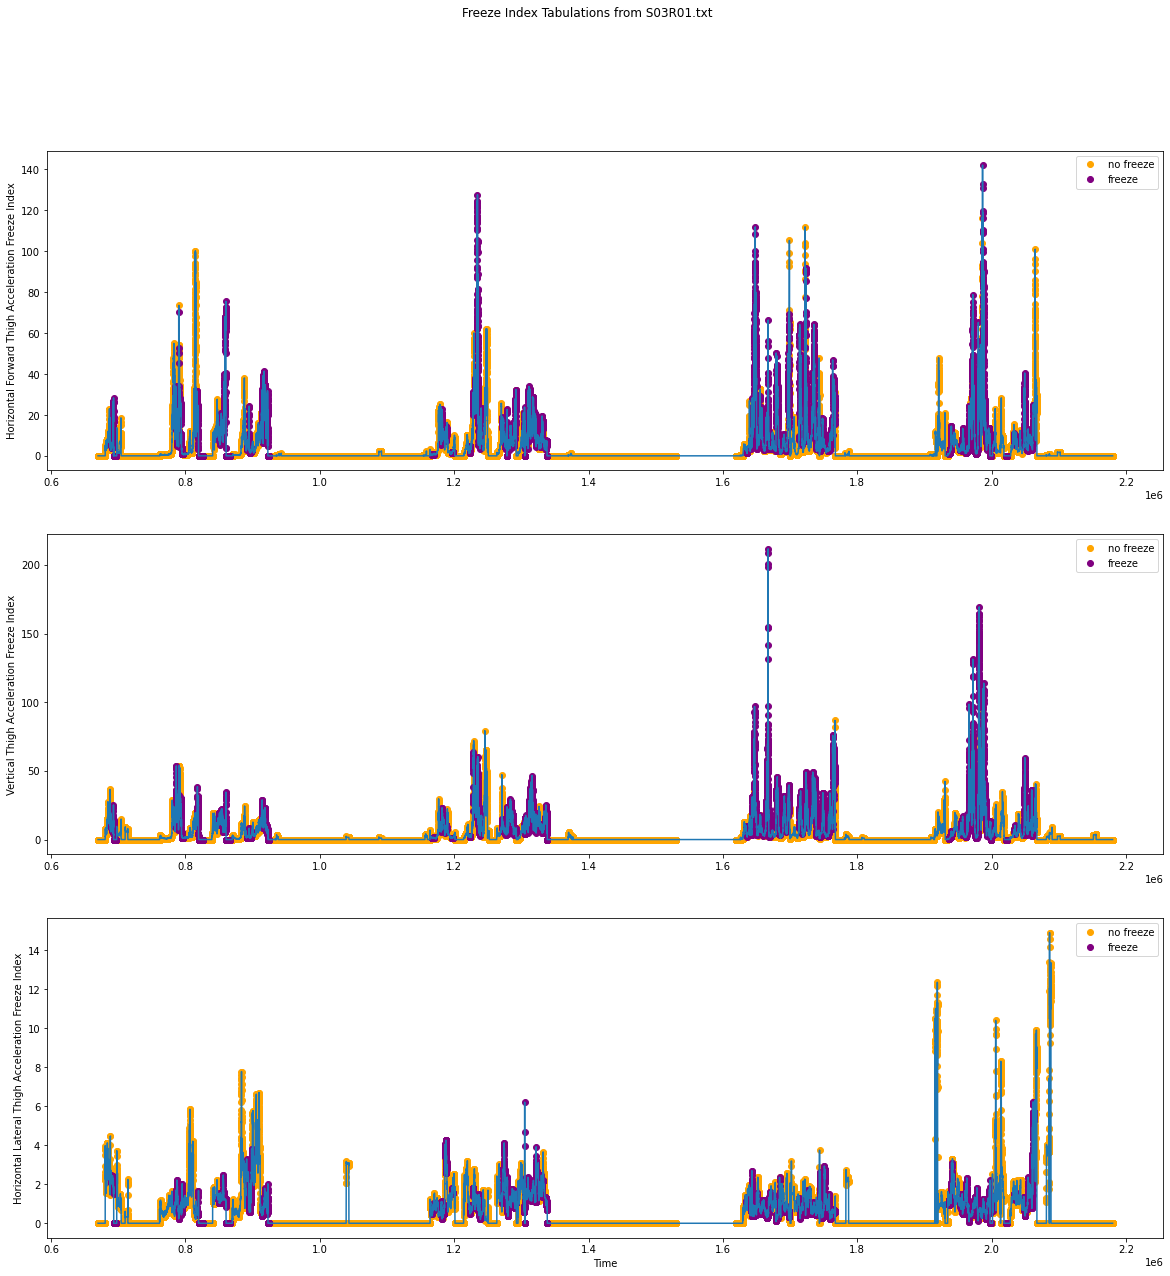

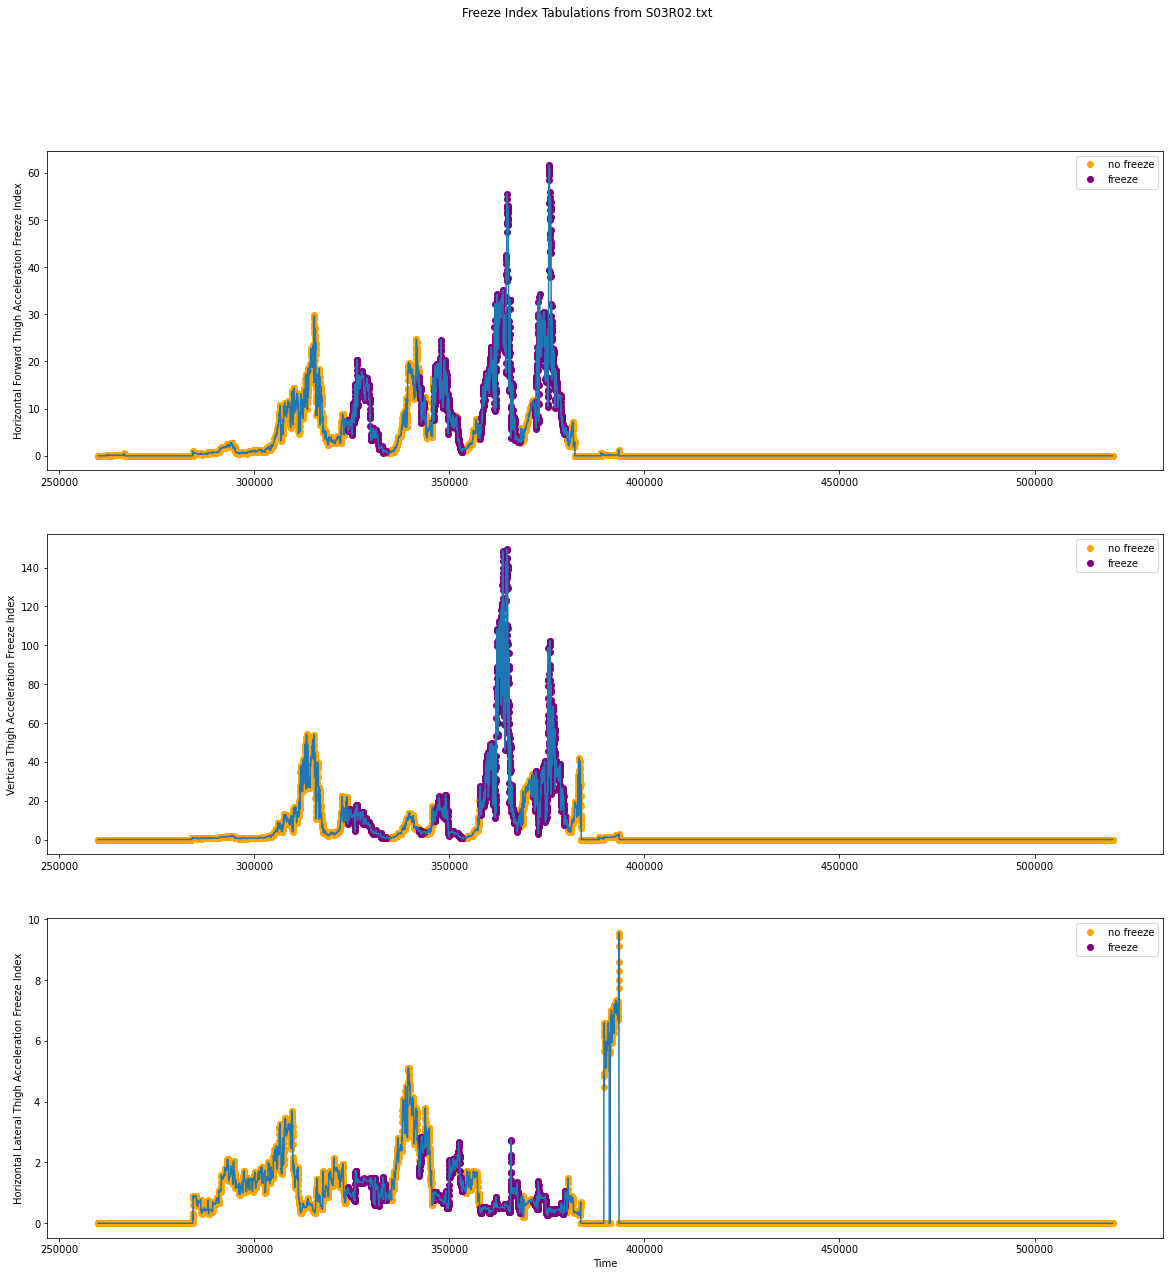

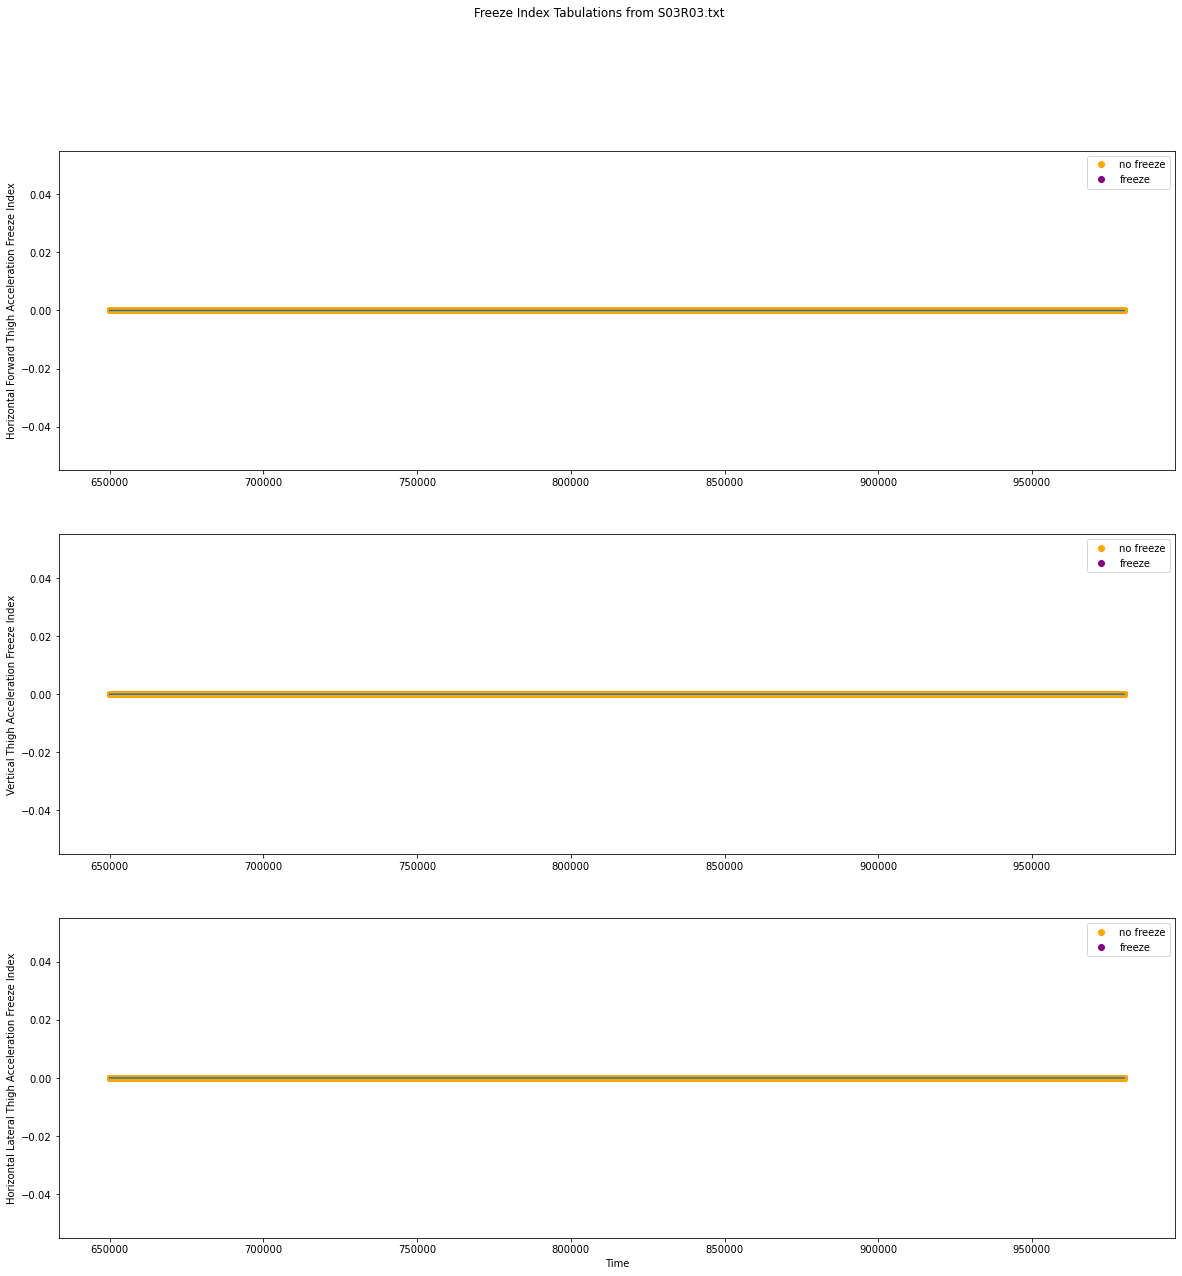

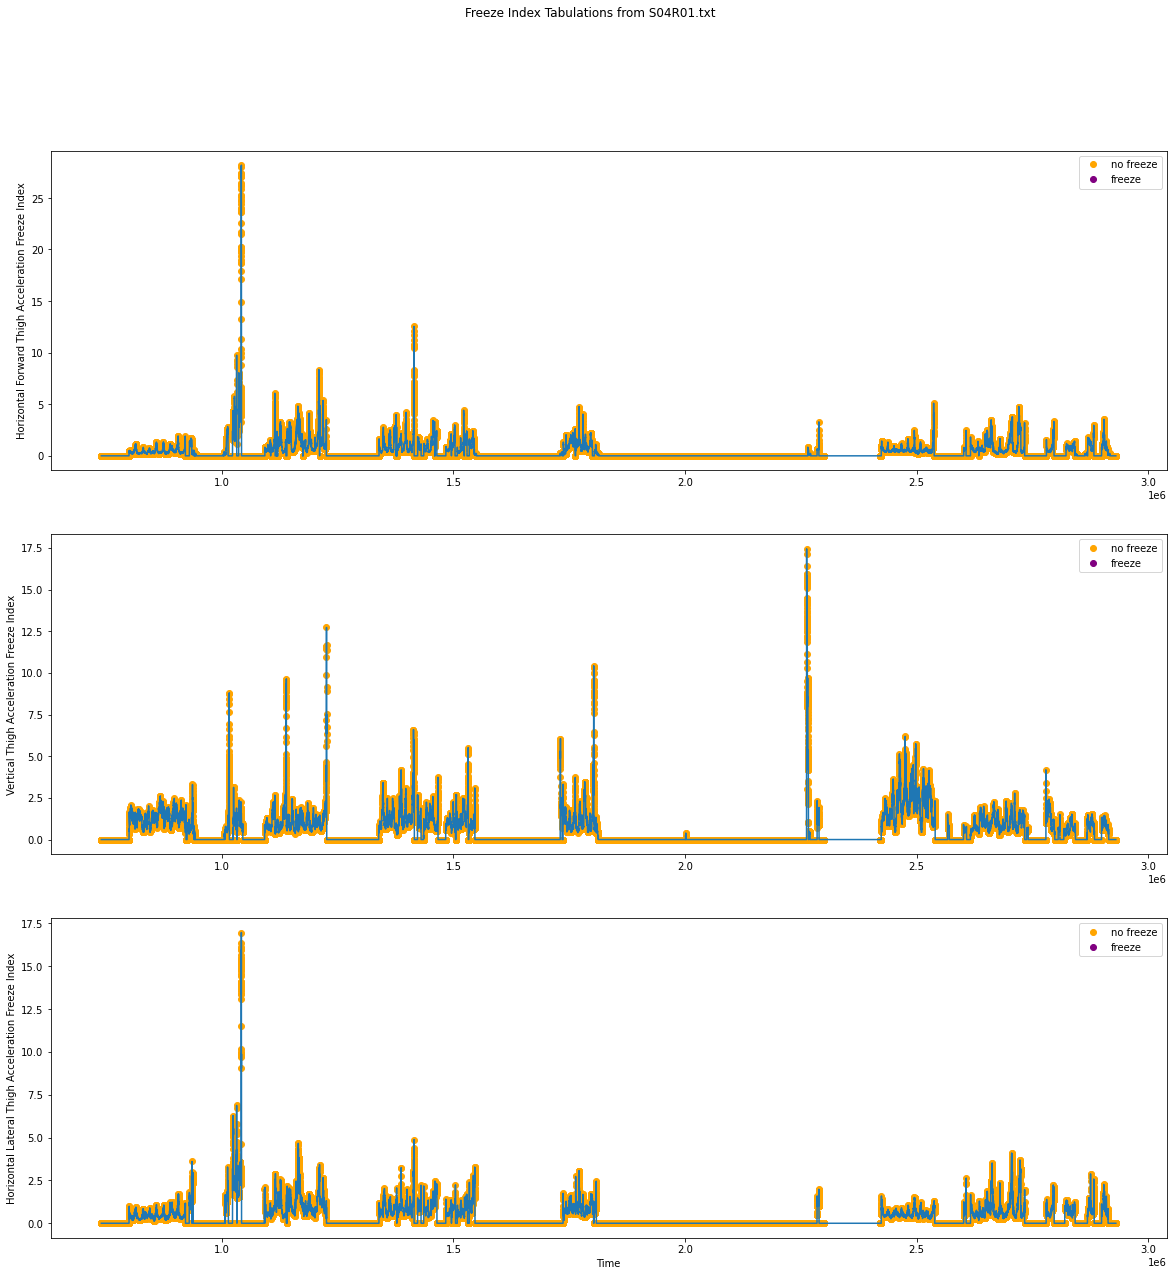

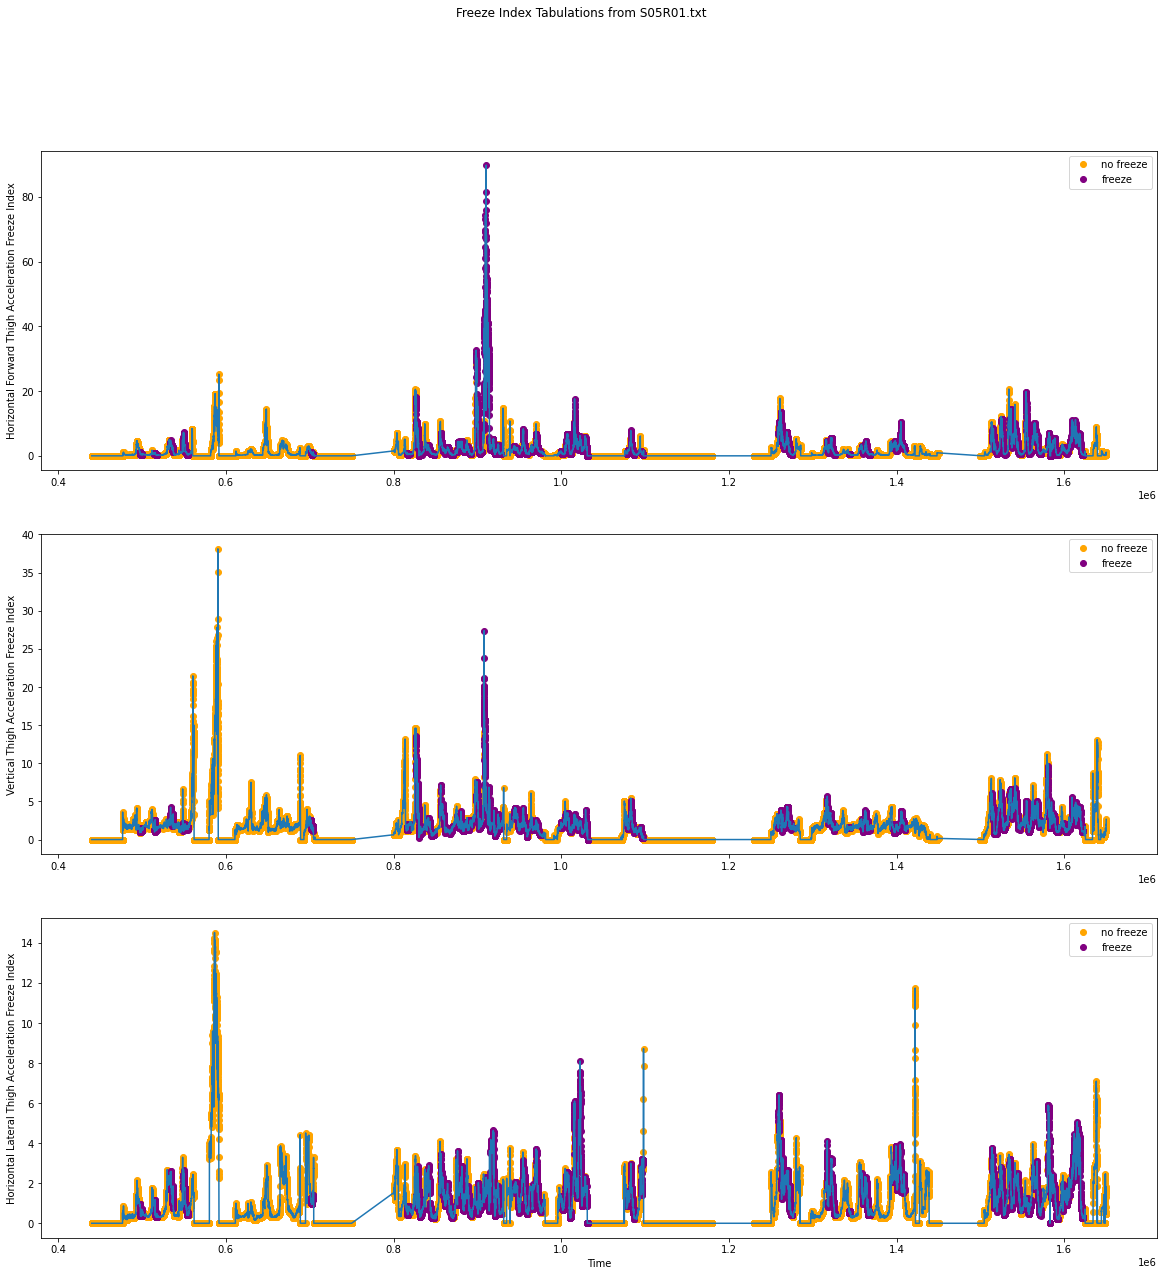

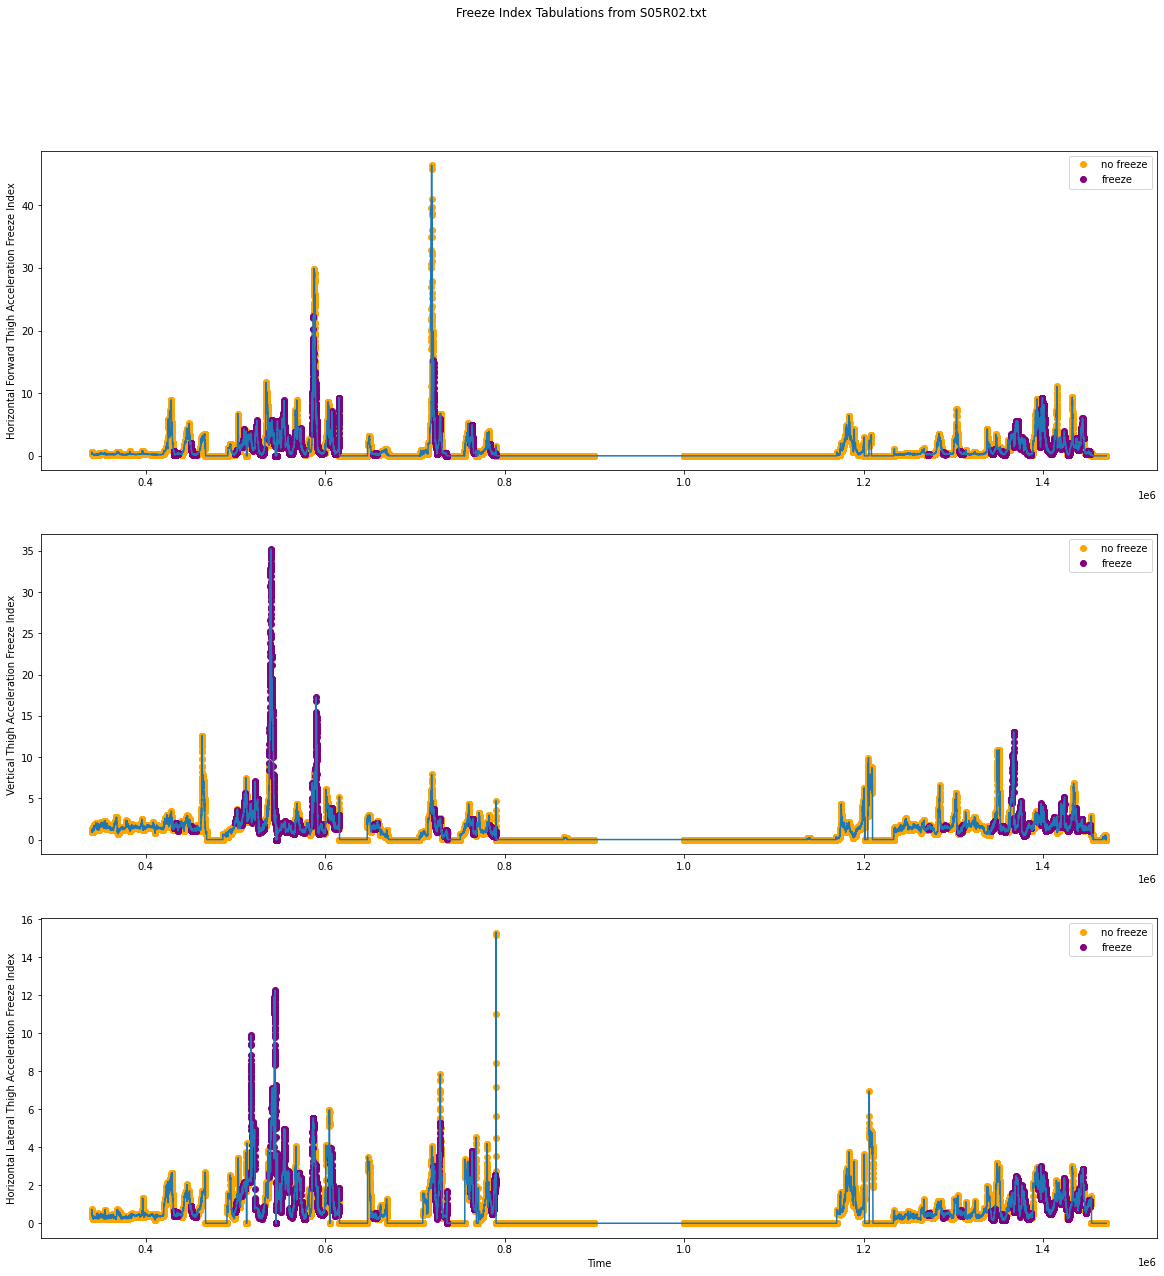

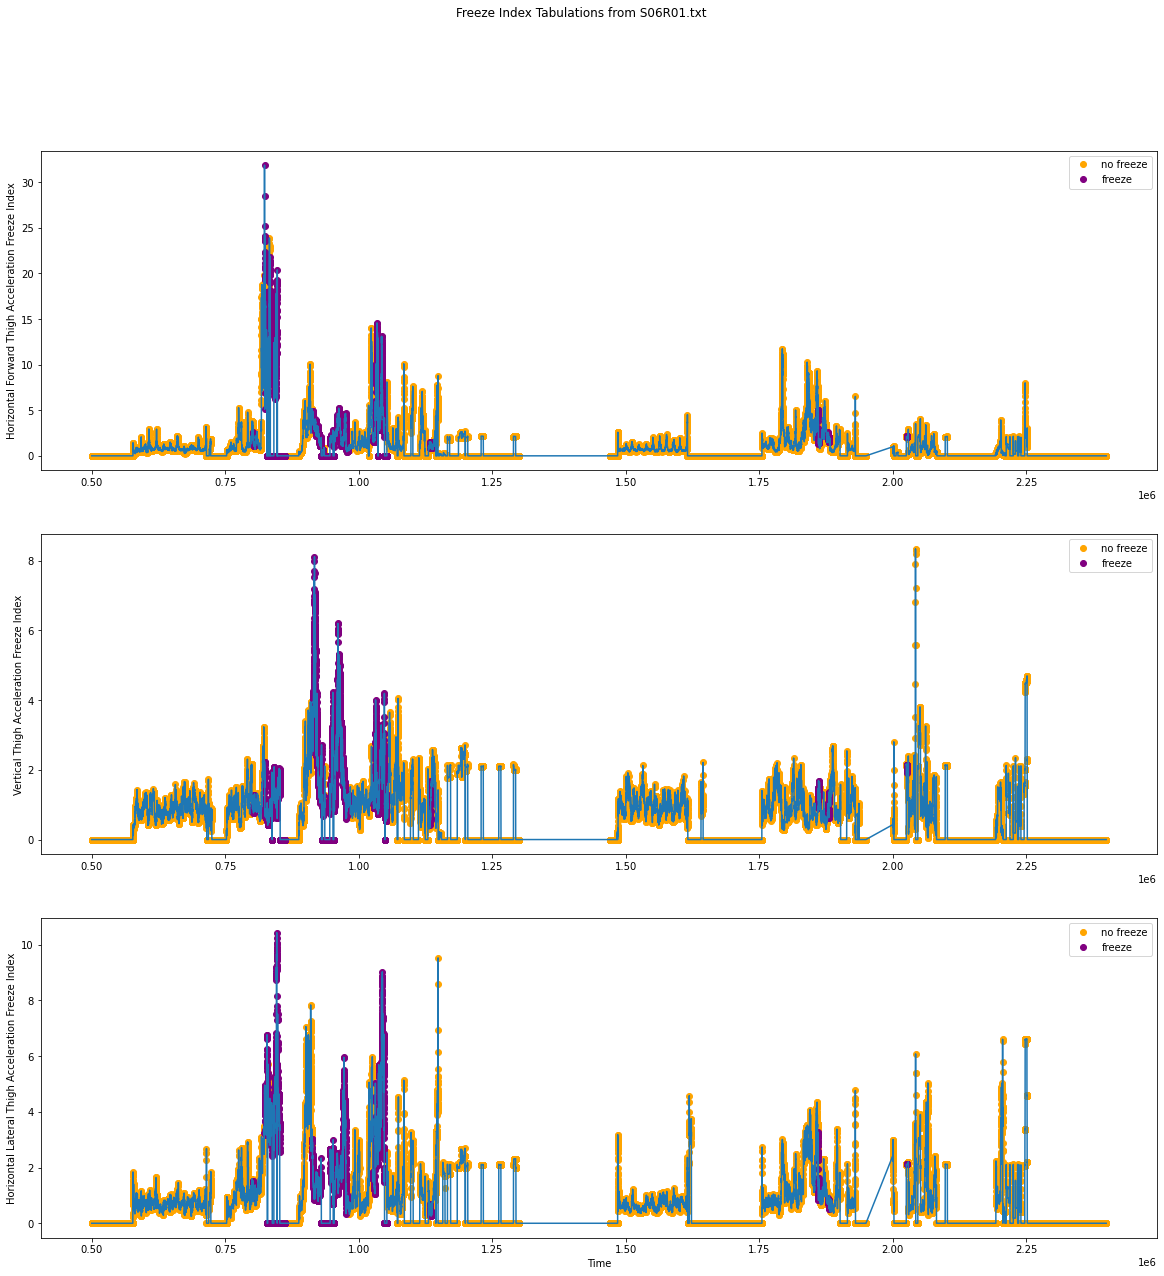

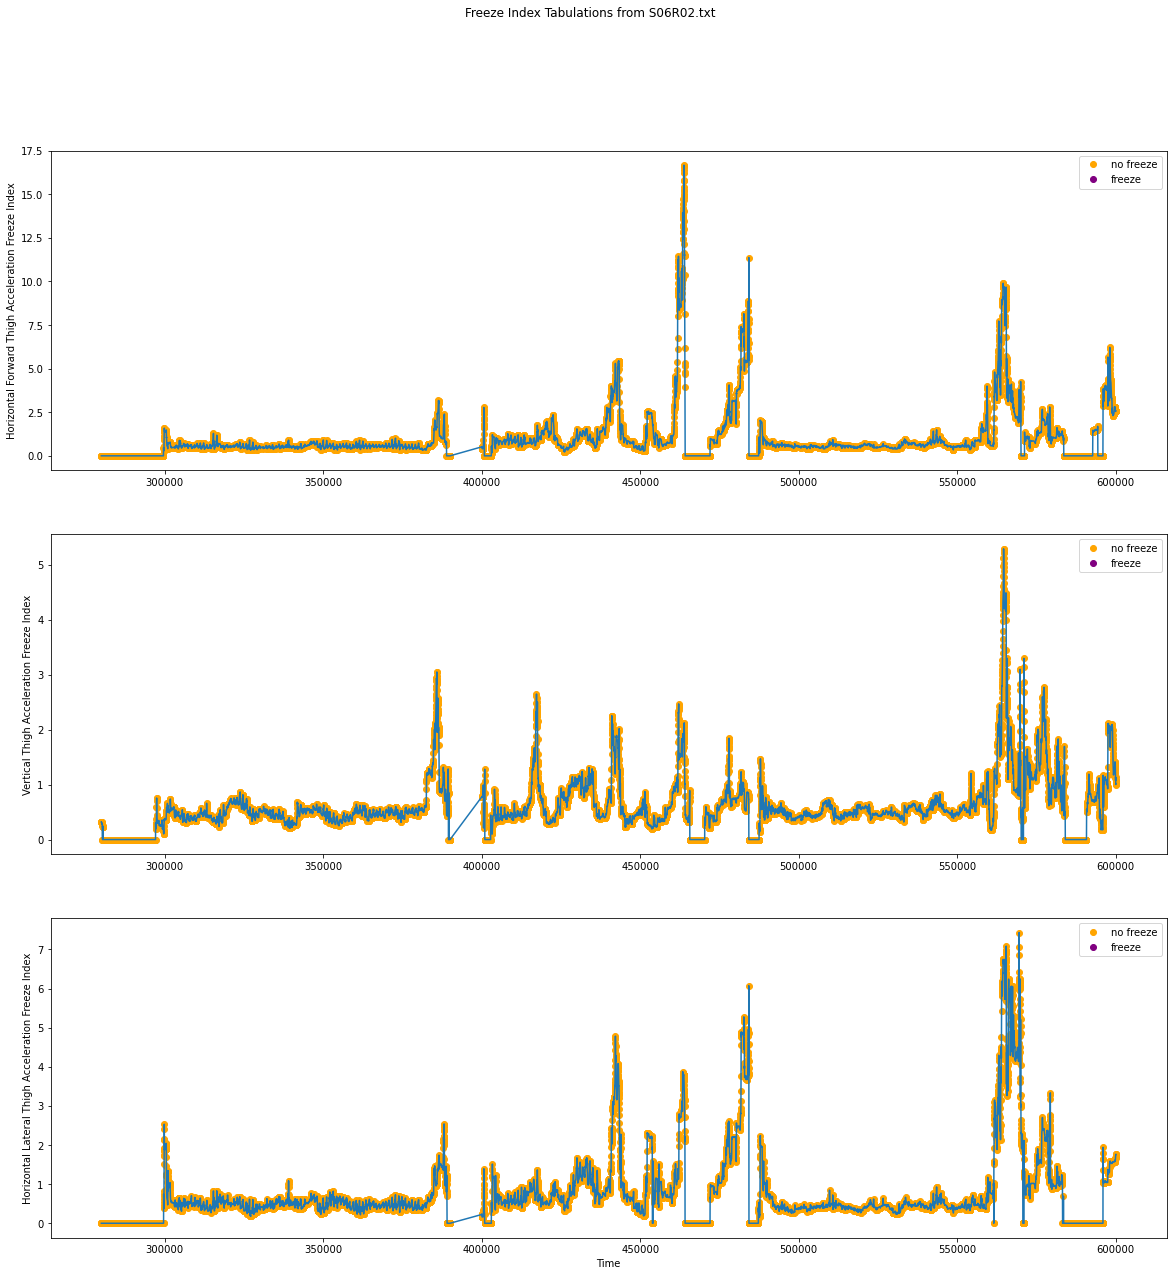

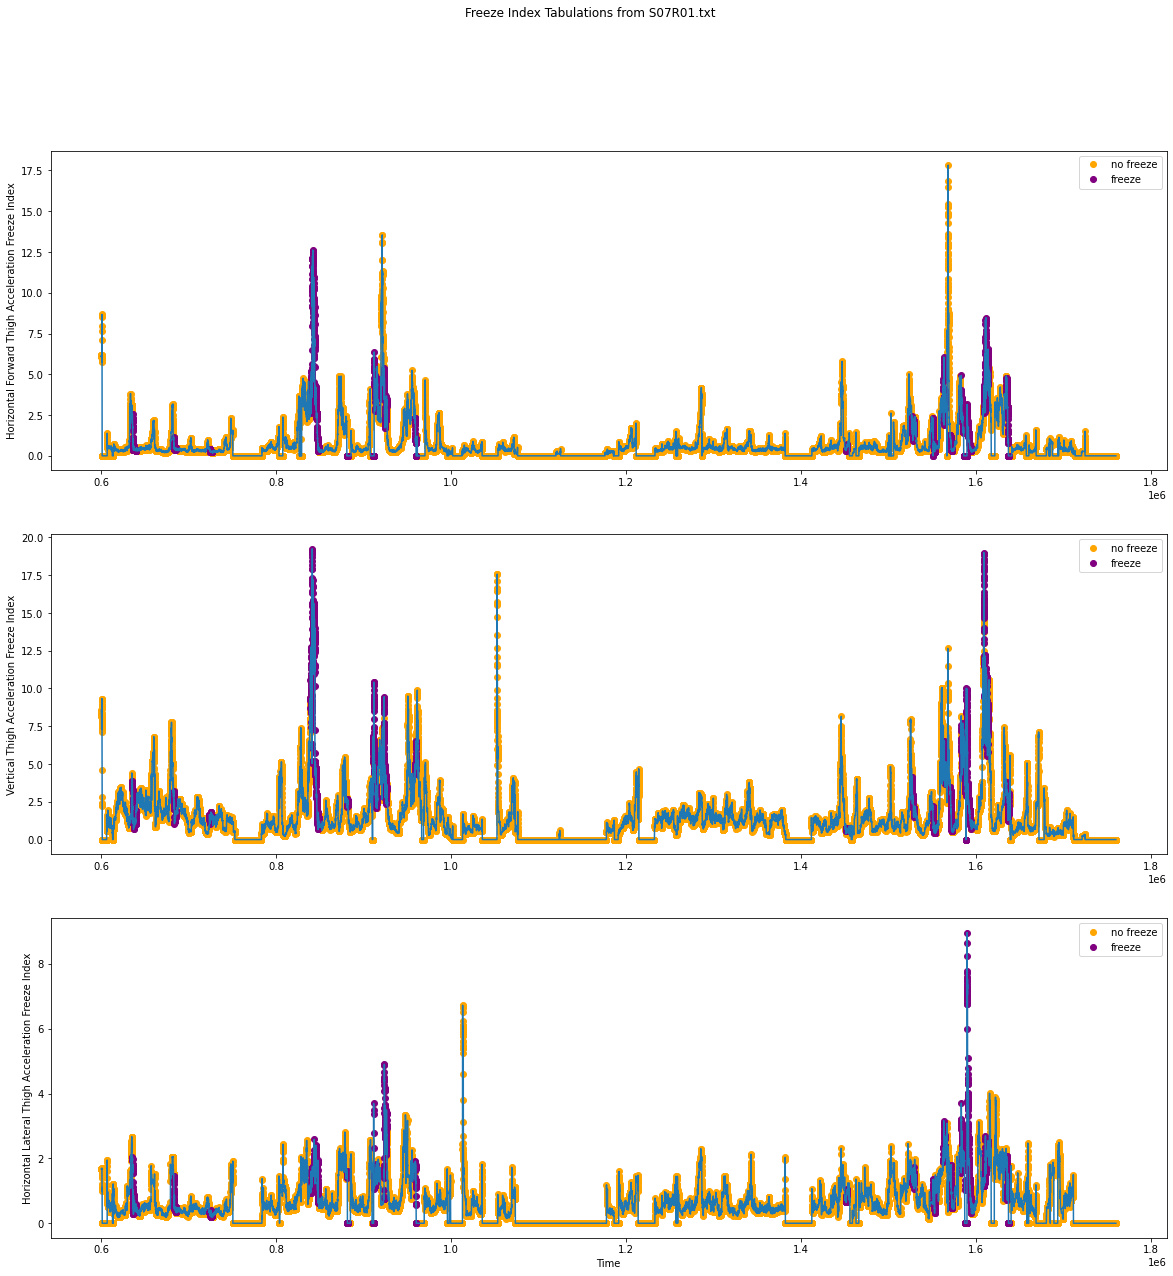

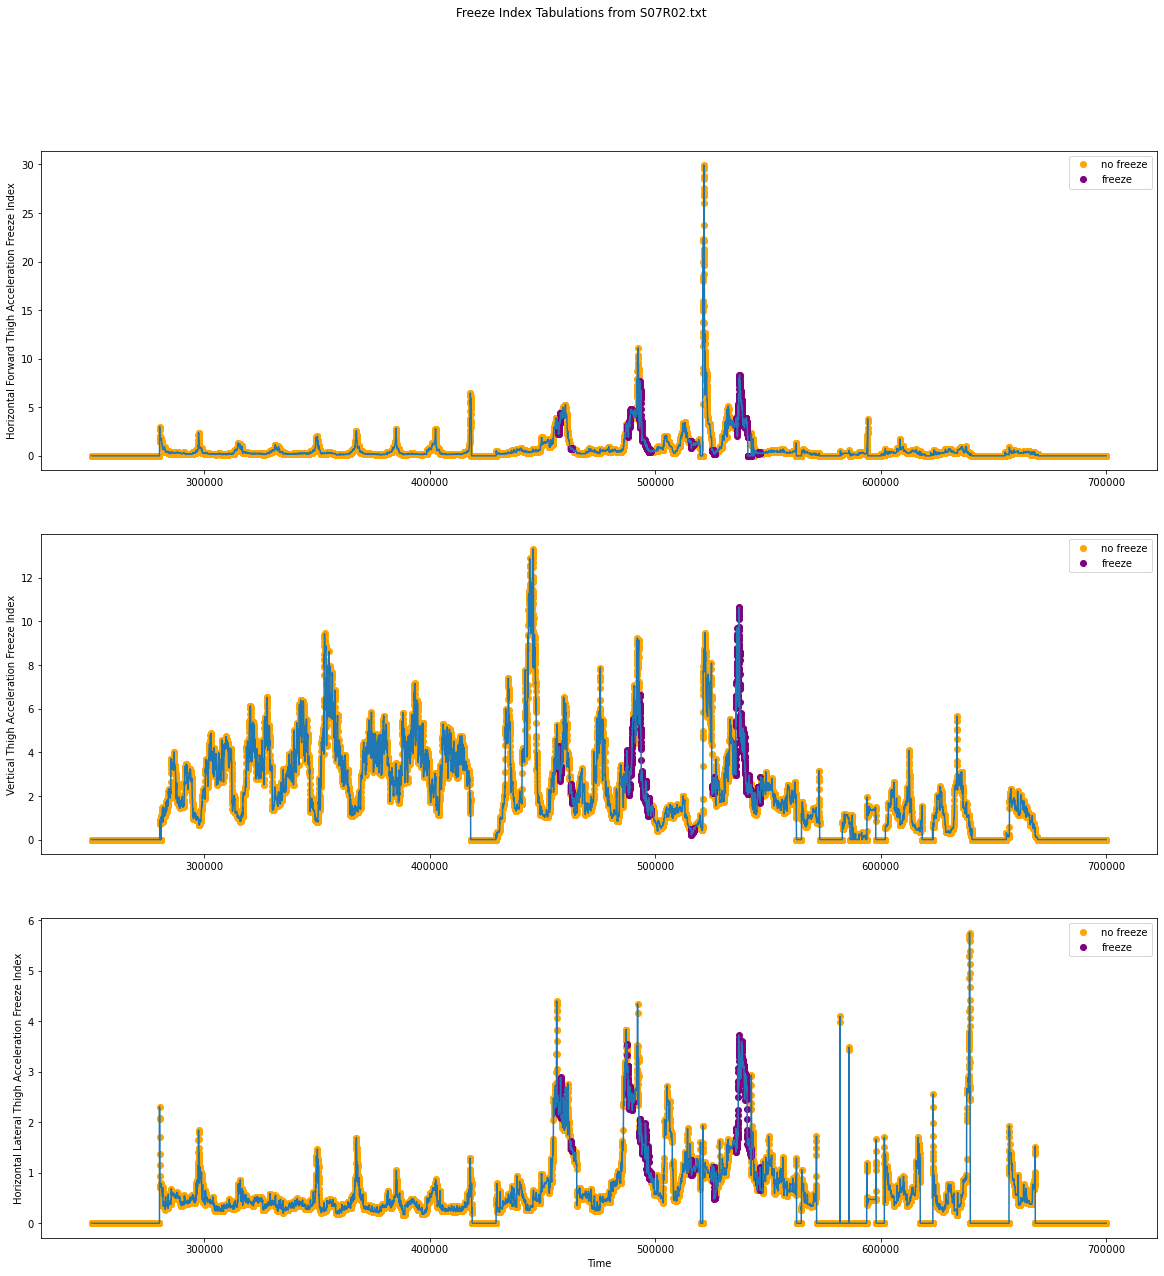

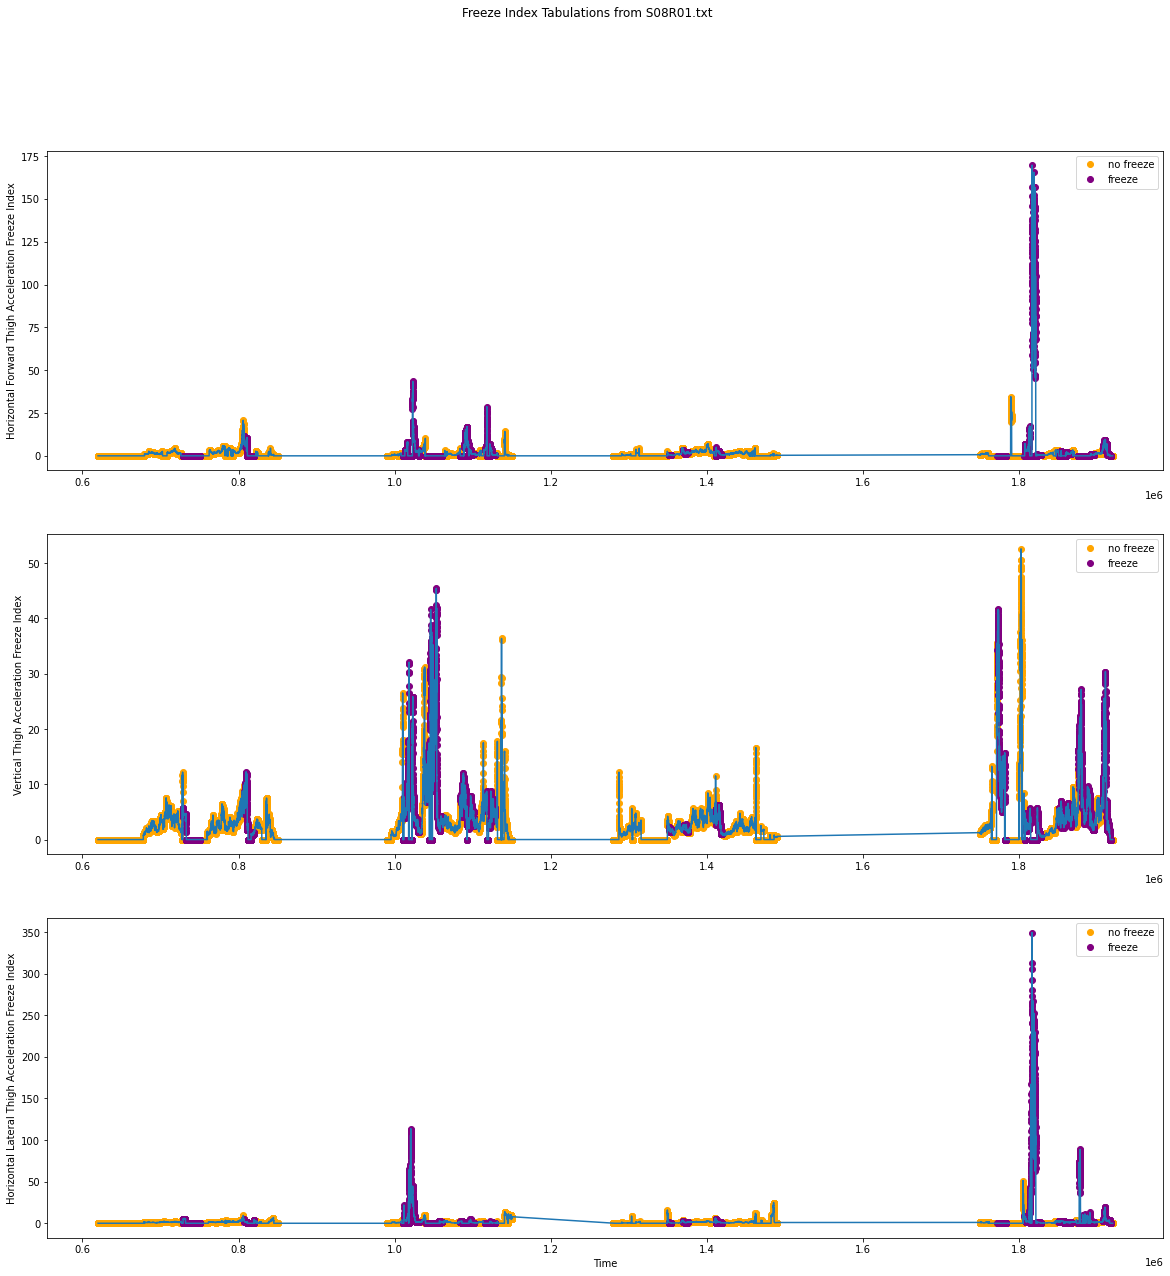

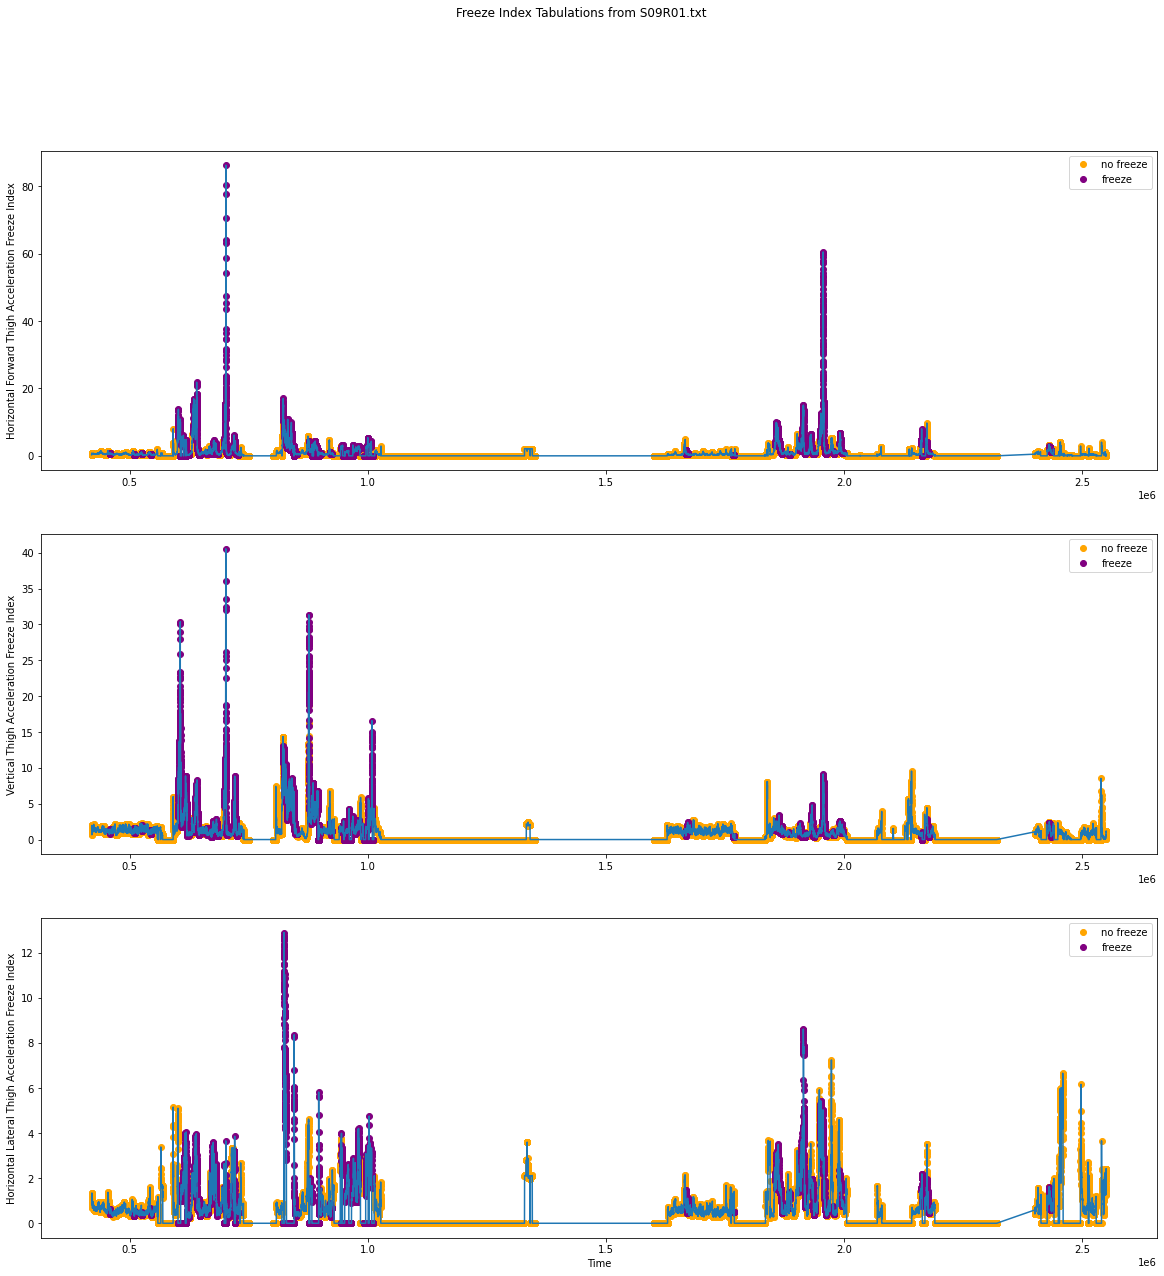

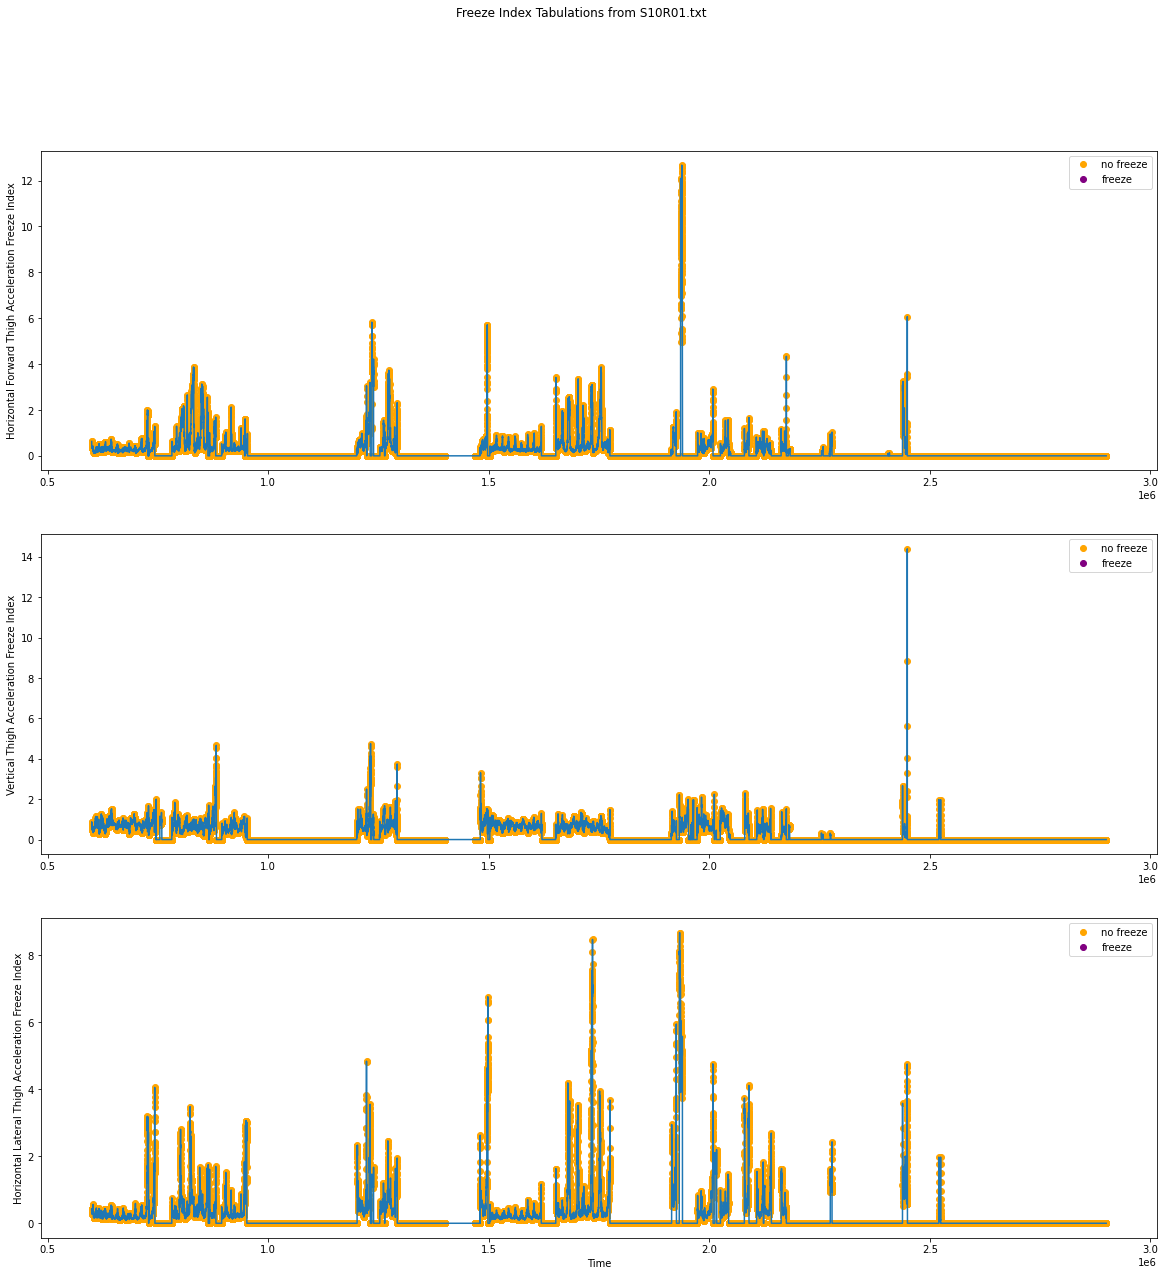

In [8]:
axesLabels = ["Horizontal Forward Thigh Acceleration", "Vertical Thigh Acceleration", "Horizontal Lateral Thigh Acceleration", "Overall Thigh Acceleration"]

for i in range(17):
    fig, axes = plt.subplots(3, 1, figsize=(20, 20))
    fig.suptitle("Freeze Index Tabulations from "+daphnetNames[i])
    plt.xlabel("Time")
    
    df = daphnetThigh[i][daphnetThigh[i].annotations != 0]
    neg = df[df.annotations == 1]
    pos = df[df.annotations == 2]
    # Ground truth of the frames
    gtframe = daphnetThigh[i].annotations.to_numpy()   # 0=no experiment, 1=no freeze, 2=freeze
    # Identify the part of the data corresponding to the experiment
    xp = np.where(gtframe != 0)
    gtframe2 = gtframe[xp]-1       # subtract 1 to have 0 or 1 as labels
    neg = np.where(gtframe2 == 0)
    pos = np.where(gtframe2 == 1)
    
    for j in range(3):
        lframe = hyp[i][j]
        lframe2 = lframe[xp]        # 0=no freeze, 1=freeze
        
        ax = axes[j]
        ax.set_ylabel(axesLabels[j]+" Freeze Index")
        ax.plot(df.index[neg], lframe2[neg], "ok", c='orange', label="no freeze")
        ax.plot(df.index[pos], lframe2[pos], "ok", c='purple', label="freeze")
        ax.plot(df.index, lframe2)
        ax.legend()
    
    plt.show()

### Set-up X-Y

#### Set-Up

In [9]:
for i in range(len(hyp)):
    hyp[i] = np.array(hyp[i])

hyp

[array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.10866475, 0.11041725, 0.11198042, ..., 0.        , 0.        ,
         0.        ],
        [0.10867678, 0.11042204, 0.11197194, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.39558639, 0.29374187, 0.22793243, ..., 0.        , 0.        ,
         0.        ],
        [0.39555996, 0.29376659, 0.22795609, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.08447839, 0.08022342, 0.07790598, ..., 0.        , 0.        ,
         0.        ],
        [0.08448746, 0.08019283, 0.0

#### Freezes

In [10]:
freezes = np.hstack(hyp)
freezes

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.10866475, 0.11041725, 0.11198042, ..., 0.        , 0.        ,
        0.        ],
       [0.10867678, 0.11042204, 0.11197194, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

#### Accelerations

In [11]:
accelerations = np.hstack([i.to_numpy().T for i in daphnetThigh])
accelerations

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#### X-Y data

In [12]:
Y = accelerations[4]
X = np.vstack((accelerations[0:4], freezes[0:3]))
xp = np.where(Y)
Y = Y[xp] - 1
X = np.array([i[0] for i in X[:,xp].T])
print(Y)
print(len(Y))
print(X.shape)
X

[0. 0. 0. ... 0. 0. 0.]
1140835
(1140835, 7)


array([[-45., 972., 181., ...,   0.,   0.,   0.],
       [-18., 981., 212., ...,   0.,   0.,   0.],
       [ 18., 981., 222., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

#### Build DataFrame

In [14]:
# Build Dataframe
df = pd.DataFrame(X, columns=["x", "y", "z", "n", "freezeX", "freezeY", "freezeZ"])
X = pd.DataFrame(X, columns=["x", "y", "z", "n", "freezeX", "freezeY", "freezeZ"])
df["freeze"] = Y
df

x      y      z            n  freezeX  freezeY  freezeZ  freeze
0       -45.0  972.0  181.0   989.732287      0.0      0.0      0.0     0.0
1       -18.0  981.0  212.0  1003.807252      0.0      0.0      0.0     0.0
2        18.0  981.0  222.0  1005.966699      0.0      0.0      0.0     0.0
3        36.0  990.0  222.0  1015.224113      0.0      0.0      0.0     0.0
4        36.0  990.0  212.0  1013.084399      0.0      0.0      0.0     0.0
...       ...    ...    ...          ...      ...      ...      ...     ...
1140830   0.0    0.0    0.0     0.000000      0.0      0.0      0.0     0.0
1140831   0.0    0.0    0.0     0.000000      0.0      0.0      0.0     0.0
1140832   0.0    0.0    0.0     0.000000      0.0      0.0      0.0     0.0
1140833   0.0    0.0    0.0     0.000000      0.0      0.0      0.0     0.0
1140834   0.0    0.0    0.0     0.000000      0.0      0.0      0.0     0.0

[1140835 rows x 8 columns]

#### Save to .csv

In [15]:
file = open("daphnet/data.csv", "w+")
df.to_csv(file, index=False)
file.close()
print(df.to_csv())

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



#### Retrieve Data

In [4]:
df = pd.read_csv("daphnet/data.csv")
X = df[["x", "y", "z", "n", "freezeX", "freezeY", "freezeZ"]]
y = df.freeze

### Plots

In [5]:
from mpl_toolkits import mplot3d

def plot_3D(x, y, z, xlabel="x", ylabel="y", zlabel="z", title="Figure", rect=[0, 0, .95, 1], elev=48, azim=134):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(x, y, z, c=y, s=5, cmap='winter')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.set_title(title)
    display(fig)
    
def plot(x, y, xlabel="x", ylabel="y", title="Figure"):
    ax = plt.subplot()
    ax.scatter(x, y, c=y, s=5, cmap='winter')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    display(fig)

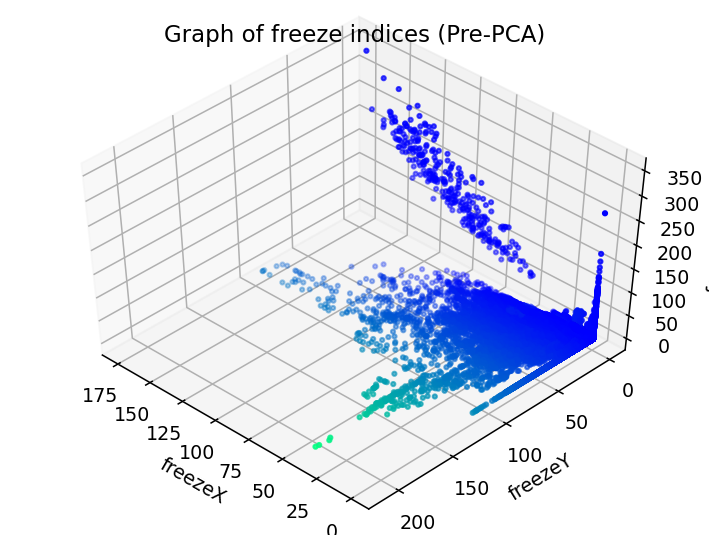

In [6]:
plot_3D(x=X.freezeX, y=X.freezeY, z=X.freezeZ,
        xlabel="freezeX", ylabel="freezeY", zlabel="freezeZ", title="Graph of freeze indices (Pre-PCA)");

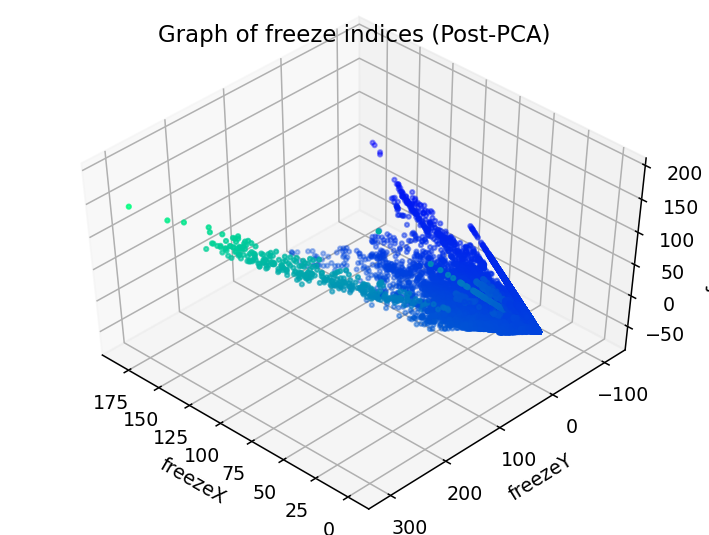

In [7]:
# PCA
from sklearn import decomposition
pca = decomposition.PCA(n_components=3)
freeze = X[["freezeX", "freezeY", "freezeZ"]]
pca.fit(freeze)
freezePCA = pca.transform(freeze)
plot_3D(x=freezePCA[:, 0], y=freezePCA[:, 1], z=freezePCA[:, 2],
        xlabel="freezeX", ylabel="freezeY", zlabel="freezeZ", title="Graph of freeze indices (Post-PCA)");

In [ ]:
plot(x=X.freezeX, y=X.freezeY, xlabel="freezeX", ylabel="freezeY", title="Plot of freezeY against freezeX")

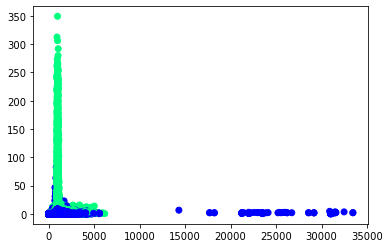

In [15]:
plt.scatter(X["n"], X["freezeZ"], c=y, cmap="winter");

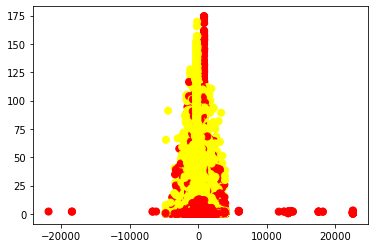

In [8]:
plt.scatter(X["x"], X["freezeX"], c=y, cmap="winter");

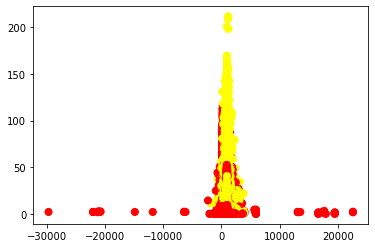

In [9]:
plt.scatter(X["y"], X["freezeY"], c=y, cmap="winter");

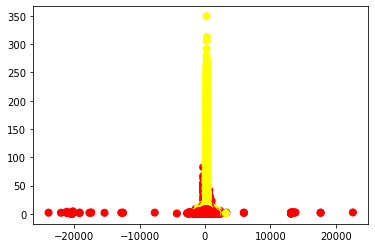

In [10]:
plt.scatter(X["z"], X["freezeZ"], c=y, s=50, cmap="winter");

In [ ]:
plt.scatter(X["freezeX"], X["freezeY"], c=y, s=50, cmap="winter");

### Support Vector Machine (SVM) Analysis

#### Train-Test Split

In [16]:
from sklearn.model_selection import train_test_split # Import train_test_split function

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20)

#### Linear SVM

##### Fit Data into Model

In [17]:
# Import svm model
from sklearn.svm import SVC

#Create a svm Classifier
svclassifier = SVC(kernel='linear', C=1E10)
svclassifier

SVC(C=10000000000.0, kernel='linear')

In [ ]:
# Train the model using the training sets
svclassifier.fit(X_train, y_train)

##### Predict

In [ ]:
# Predict the response for test dataset
y_pred = svclassifier.predict(X_test)
y_pred

##### Evaluating the Model
Confusion matrix, precision, recall, and F1 measures are the most commonly used metrics for classification tasks. Scikit-Learn's ```metrics``` library contains the ```accuracy_score```, ```classification_report``` and ```confusion_matrix``` methods, which can be readily used to find out the values for these important metrics.

In [ ]:
# Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Model Accuracy: how often is the classifier correct?
print("Accuracy:", accuracy_score(y_test, y_pred))

print(confusion_matrix(y_test,y_pred))

print(classification_report(y_test,y_pred))

#### Radial 

### Testing the Hypothesis

In [42]:
def print(*args, sep=" ", end="\n"):
    string = sep.join([str(i) for i in args])+end
    display(Markdown(string))

from scripts.accuracy import *
offDelay = 2       # Evaluation delay in seconds: tolerates delay after detecting
onDelay = 2        # Evaluation delay in seconds: tolerates delay before detecting

axes = ["Horizontal Forward Thigh Acceleration", "Vertical Thigh Acceleration", "Horizontal Lateral Thigh Acceleration", "Overall Thigh Acceleration"]
axesComp = [0, 0, 0, 0]

for i in range(17):
    df = daphnetThigh[i]
    # Ground truth of the frames
    gtframe = df.annotations.to_numpy()  # 0=no experiment, 1=no freeze, 2=freeze
    # Identify the part of the data corresponding to the experiment
    xp = np.where(gtframe != 0)
    gtframe2 = gtframe[xp]-1       # subtract 1 to have 0 or 1 as labels
    
    print("#", daphnetNames[i])
    for j in range(4):
        lframe = hyp[i][j]
        lframe2 = lframe[xp]           # 0=no freeze, 1=freeze
        res_vec = np.zeros((np.size(gtframe2), 6)); # TP TPd TN TNd FP FN

        # mark all correct detected (TP) and not detected (TN) time-slots
        i_TX = np.array(np.where(gtframe2 == lframe2)); # all correct time-slots

        i_TP = np.where(lframe2[i_TX] == 1); # correct detected
        res_vec[i_TX[i_TP], 0] = 1;

        i_TN = np.where(lframe2[i_TX] == 0); # correct not detected
        res_vec[i_TX[i_TN], 2] = 1;

        # mark all false detected (FP) and missed (FN) time-slots
        i_FX = np.array(np.where(gtframe2 != lframe2)); # all wrong time-slots

        i_FP = np.where(lframe2[i_FX] == 1); # wrong detected
        res_vec[i_FX[i_FP], 4] = 1;

        i_FN = np.where(lframe2[i_FX] == 0); # missed
        res_vec[i_FX[i_FN], 5] = 1;
        

        # sum up result
        TP = np.sum(res_vec[:,0]) + np.sum(res_vec[:,1]);
        TN = np.sum(res_vec[:,2]) + np.sum(res_vec[:,3]);
        FP = np.sum(res_vec[:,4]);
        FN = np.sum(res_vec[:,5]);
        all = [TP, TN, FP, FN]
        axesComp[j] += np.array(all)
        
        print("##", axes[j])
        print("**TP**:", TP, "\n\n**FP**:", FP, "\n\n**TN**:", TN, "\n\n**FN**:", FN) # tp, fp, tn, fn
        print("\n**Precision**:", precision(*all))
        print("**Recall**:", recall(*all))
        print("\n\n**Sensitivity**:", recall(*all))
        print("**Specificity**:", specificity(*all))
        print("\n\n**F1**:", f1(*all), end="\n\n\n")
    
    print()
    

# S01R01.txt


## Horizontal Forward Thigh Acceleration


**TP**: 4213.0 

**FP**: 23577.0 

**TN**: 64078.0 

**FN**: 934.0



**Precision**: 0.06169187740697896


**Recall**: 0.8185350689722168




**Sensitivity**: 0.8185350689722168


**Specificity**: 0.26897495864468657




**F1**: 0.11473624009368447




## Vertical Thigh Acceleration


**TP**: 4403.0 

**FP**: 54610.0 

**TN**: 33045.0 

**FN**: 744.0



**Precision**: 0.11757637256996369


**Recall**: 0.8554497765688751




**Sensitivity**: 0.8554497765688751


**Specificity**: 0.6230106668187781




**F1**: 0.20673788003286772




## Horizontal Lateral Thigh Acceleration


**TP**: 2951.0 

**FP**: 12888.0 

**TN**: 74767.0 

**FN**: 2196.0



**Precision**: 0.037970611698705574


**Recall**: 0.5733436953565184




**Sensitivity**: 0.5733436953565184


**Specificity**: 0.14703097370372484




**F1**: 0.07122428045616365




## Overall Thigh Acceleration


**TP**: 0.0 

**FP**: 0.0 

**TN**: 87655.0 

**FN**: 5147.0



**Precision**: 0.0


**Recall**: 0.0




**Sensitivity**: 0.0


**Specificity**: 0.0




**F1**: nan




# S01R02.txt


## Horizontal Forward Thigh Acceleration


**TP**: 1169.0 

**FP**: 7112.0 

**TN**: 20142.0 

**FN**: 378.0



**Precision**: 0.05485430059593637


**Recall**: 0.755656108597285




**Sensitivity**: 0.755656108597285


**Specificity**: 0.26095252073090186




**F1**: 0.10228366436258642




## Vertical Thigh Acceleration


**TP**: 1459.0 

**FP**: 15170.0 

**TN**: 12084.0 

**FN**: 88.0



**Precision**: 0.10773093110832165


**Recall**: 0.9431157078215902




**Sensitivity**: 0.9431157078215902


**Specificity**: 0.5566155426726352




**F1**: 0.19337309476474485




## Horizontal Lateral Thigh Acceleration


**TP**: 699.0 

**FP**: 5186.0 

**TN**: 22068.0 

**FN**: 848.0



**Precision**: 0.030702332323099223


**Recall**: 0.45184227537168714




**Sensitivity**: 0.45184227537168714


**Specificity**: 0.1902839950099068




**F1**: 0.05749773792876532




## Overall Thigh Acceleration


**TP**: 0.0 

**FP**: 0.0 

**TN**: 27254.0 

**FN**: 1547.0



**Precision**: 0.0


**Recall**: 0.0




**Sensitivity**: 0.0


**Specificity**: 0.0




**F1**: nan




# S02R01.txt


## Horizontal Forward Thigh Acceleration


**TP**: 2261.0 

**FP**: 808.0 

**TN**: 21256.0 

**FN**: 1276.0



**Precision**: 0.09614321554620062


**Recall**: 0.6392422957308453




**Sensitivity**: 0.6392422957308453


**Specificity**: 0.03662073966642494




**F1**: 0.16714718710726695




## Vertical Thigh Acceleration


**TP**: 2939.0 

**FP**: 5307.0 

**TN**: 16757.0 

**FN**: 598.0



**Precision**: 0.14921811535337123


**Recall**: 0.8309301668080294




**Sensitivity**: 0.8309301668080294


**Specificity**: 0.24052755620014504




**F1**: 0.2530021951534455




## Horizontal Lateral Thigh Acceleration


**TP**: 1641.0 

**FP**: 737.0 

**TN**: 21327.0 

**FN**: 1896.0



**Precision**: 0.07144723092998954


**Recall**: 0.46395250212044103




**Sensitivity**: 0.46395250212044103


**Specificity**: 0.03340282813633067




**F1**: 0.12382569326542162




## Overall Thigh Acceleration


**TP**: 0.0 

**FP**: 0.0 

**TN**: 22064.0 

**FN**: 3537.0



**Precision**: 0.0


**Recall**: 0.0




**Sensitivity**: 0.0


**Specificity**: 0.0




**F1**: nan




# S02R02.txt


## Horizontal Forward Thigh Acceleration


**TP**: 5086.0 

**FP**: 5088.0 

**TN**: 51801.0 

**FN**: 2986.0



**Precision**: 0.08940531228575949


**Recall**: 0.6300792864222002




**Sensitivity**: 0.6300792864222002


**Specificity**: 0.08943732531772398




**F1**: 0.1565910805277175




## Vertical Thigh Acceleration


**TP**: 5890.0 

**FP**: 13994.0 

**TN**: 42895.0 

**FN**: 2182.0



**Precision**: 0.12073383212052885


**Recall**: 0.7296828543111992




**Sensitivity**: 0.7296828543111992


**Specificity**: 0.24598780080507654




**F1**: 0.2071864502172116




## Horizontal Lateral Thigh Acceleration


**TP**: 3391.0 

**FP**: 6335.0 

**TN**: 50554.0 

**FN**: 4681.0



**Precision**: 0.06286032069700621


**Recall**: 0.42009415262636274




**Sensitivity**: 0.42009415262636274


**Specificity**: 0.11135720438046019




**F1**: 0.10935711175967881




## Overall Thigh Acceleration


**TP**: 0.0 

**FP**: 0.0 

**TN**: 56889.0 

**FN**: 8072.0



**Precision**: 0.0


**Recall**: 0.0




**Sensitivity**: 0.0


**Specificity**: 0.0




**F1**: nan




# S03R01.txt


## Horizontal Forward Thigh Acceleration


**TP**: 14071.0 

**FP**: 17779.0 

**TN**: 57069.0 

**FN**: 1963.0



**Precision**: 0.19779308405960078


**Recall**: 0.8775726581015343




**Sensitivity**: 0.8775726581015343


**Specificity**: 0.2375347370671227




**F1**: 0.32282561314153296




## Vertical Thigh Acceleration


**TP**: 14259.0 

**FP**: 21498.0 

**TN**: 53350.0 

**FN**: 1775.0



**Precision**: 0.2109038737446198


**Recall**: 0.8892977422976176




**Sensitivity**: 0.8892977422976176


**Specificity**: 0.2872221034630184




**F1**: 0.3409490333919156




## Horizontal Lateral Thigh Acceleration


**TP**: 2999.0 

**FP**: 8476.0 

**TN**: 66372.0 

**FN**: 13035.0



**Precision**: 0.04323132144556083


**Recall**: 0.18704003991518023




**Sensitivity**: 0.18704003991518023


**Specificity**: 0.11324283882000855




**F1**: 0.07023008020607693




## Overall Thigh Acceleration


**TP**: 0.0 

**FP**: 0.0 

**TN**: 74848.0 

**FN**: 16034.0



**Precision**: 0.0


**Recall**: 0.0




**Sensitivity**: 0.0


**Specificity**: 0.0




**F1**: nan




# S03R02.txt


## Horizontal Forward Thigh Acceleration


**TP**: 2221.0 

**FP**: 2772.0 

**TN**: 11563.0 

**FN**: 85.0



**Precision**: 0.1611288450377249


**Recall**: 0.9631396357328708




**Sensitivity**: 0.9631396357328708


**Specificity**: 0.19337286362050923




**F1**: 0.276072094468614




## Vertical Thigh Acceleration


**TP**: 2189.0 

**FP**: 2752.0 

**TN**: 11583.0 

**FN**: 117.0



**Precision**: 0.15894568690095848


**Recall**: 0.9492627927146574




**Sensitivity**: 0.9492627927146574


**Specificity**: 0.19197767701430066




**F1**: 0.2722975494464486




## Horizontal Lateral Thigh Acceleration


**TP**: 230.0 

**FP**: 1847.0 

**TN**: 12488.0 

**FN**: 2076.0



**Precision**: 0.01808460449756251


**Recall**: 0.0997398091934085




**Sensitivity**: 0.0997398091934085


**Specificity**: 0.1288454830833624




**F1**: 0.030617678381256657




## Overall Thigh Acceleration


**TP**: 0.0 

**FP**: 0.0 

**TN**: 14335.0 

**FN**: 2306.0



**Precision**: 0.0


**Recall**: 0.0




**Sensitivity**: 0.0


**Specificity**: 0.0




**F1**: nan




# S03R03.txt


## Horizontal Forward Thigh Acceleration


**TP**: 0.0 

**FP**: 0.0 

**TN**: 21121.0 

**FN**: 0.0



**Precision**: 0.0


**Recall**: nan




**Sensitivity**: nan


**Specificity**: 0.0




**F1**: nan




## Vertical Thigh Acceleration


**TP**: 0.0 

**FP**: 0.0 

**TN**: 21121.0 

**FN**: 0.0



**Precision**: 0.0


**Recall**: nan




**Sensitivity**: nan


**Specificity**: 0.0




**F1**: nan




## Horizontal Lateral Thigh Acceleration


**TP**: 0.0 

**FP**: 0.0 

**TN**: 21121.0 

**FN**: 0.0



**Precision**: 0.0


**Recall**: nan




**Sensitivity**: nan


**Specificity**: 0.0




**F1**: nan




## Overall Thigh Acceleration


**TP**: 0.0 

**FP**: 0.0 

**TN**: 21121.0 

**FN**: 0.0



**Precision**: 0.0


**Recall**: nan




**Sensitivity**: nan


**Specificity**: 0.0




**F1**: nan




# S04R01.txt


## Horizontal Forward Thigh Acceleration


**TP**: 0.0 

**FP**: 8588.0 

**TN**: 123894.0 

**FN**: 0.0



**Precision**: 0.0


**Recall**: nan




**Sensitivity**: nan


**Specificity**: 0.06482390060536526




**F1**: nan




## Vertical Thigh Acceleration


**TP**: 0.0 

**FP**: 15314.0 

**TN**: 117168.0 

**FN**: 0.0



**Precision**: 0.0


**Recall**: nan




**Sensitivity**: nan


**Specificity**: 0.11559306169894779




**F1**: nan




## Horizontal Lateral Thigh Acceleration


**TP**: 0.0 

**FP**: 5867.0 

**TN**: 126615.0 

**FN**: 0.0



**Precision**: 0.0


**Recall**: nan




**Sensitivity**: nan


**Specificity**: 0.04428526139400069




**F1**: nan




## Overall Thigh Acceleration


**TP**: 0.0 

**FP**: 0.0 

**TN**: 132482.0 

**FN**: 0.0



**Precision**: 0.0


**Recall**: nan




**Sensitivity**: nan


**Specificity**: 0.0




**F1**: nan




# S05R01.txt


## Horizontal Forward Thigh Acceleration


**TP**: 11008.0 

**FP**: 9104.0 

**TN**: 41387.0 

**FN**: 6345.0



**Precision**: 0.21009638324267582


**Recall**: 0.6343571716706045




**Sensitivity**: 0.6343571716706045


**Specificity**: 0.18030936206452636




**F1**: 0.31565062797499566




## Vertical Thigh Acceleration


**TP**: 12718.0 

**FP**: 20617.0 

**TN**: 29874.0 

**FN**: 4635.0



**Precision**: 0.2986006761833208


**Recall**: 0.7328992105111508




**Sensitivity**: 0.7328992105111508


**Specificity**: 0.40833019746093363




**F1**: 0.4243222954374844




## Horizontal Lateral Thigh Acceleration


**TP**: 8726.0 

**FP**: 8021.0 

**TN**: 42470.0 

**FN**: 8627.0



**Precision**: 0.17044300335963747


**Recall**: 0.502852532703279




**Sensitivity**: 0.502852532703279


**Specificity**: 0.15885999485056743




**F1**: 0.25459160600446396




## Overall Thigh Acceleration


**TP**: 0.0 

**FP**: 0.0 

**TN**: 50491.0 

**FN**: 17353.0



**Precision**: 0.0


**Recall**: 0.0




**Sensitivity**: 0.0


**Specificity**: 0.0




**F1**: nan




# S05R02.txt


## Horizontal Forward Thigh Acceleration


**TP**: 5828.0 

**FP**: 6936.0 

**TN**: 45969.0 

**FN**: 7189.0



**Precision**: 0.11251616889009015


**Recall**: 0.4477222094184528




**Sensitivity**: 0.4477222094184528


**Specificity**: 0.1311029203288914




**F1**: 0.17983768938809516




## Vertical Thigh Acceleration


**TP**: 7053.0 

**FP**: 13487.0 

**TN**: 39418.0 

**FN**: 5964.0



**Precision**: 0.15177207290568312


**Recall**: 0.5418299147268956




**Sensitivity**: 0.5418299147268956


**Specificity**: 0.254928645685663




**F1**: 0.23712345346960728




## Horizontal Lateral Thigh Acceleration


**TP**: 4516.0 

**FP**: 5286.0 

**TN**: 47619.0 

**FN**: 8501.0



**Precision**: 0.08662127169847511


**Recall**: 0.34693093646769607




**Sensitivity**: 0.34693093646769607


**Specificity**: 0.09991494187694924




**F1**: 0.1386296660117878




## Overall Thigh Acceleration


**TP**: 0.0 

**FP**: 0.0 

**TN**: 52905.0 

**FN**: 13017.0



**Precision**: 0.0


**Recall**: 0.0




**Sensitivity**: 0.0


**Specificity**: 0.0




**F1**: nan




# S06R01.txt


## Horizontal Forward Thigh Acceleration


**TP**: 4913.0 

**FP**: 14547.0 

**TN**: 84563.0 

**FN**: 3500.0



**Precision**: 0.054908578836783045


**Recall**: 0.5839771781766314




**Sensitivity**: 0.5839771781766314


**Specificity**: 0.14677630915144788




**F1**: 0.10037900070488001




## Vertical Thigh Acceleration


**TP**: 3548.0 

**FP**: 8754.0 

**TN**: 90356.0 

**FN**: 4865.0



**Precision**: 0.037783268018401775


**Recall**: 0.4217282776655176




**Sensitivity**: 0.4217282776655176


**Specificity**: 0.08832610231056402




**F1**: 0.06935308892950341




## Horizontal Lateral Thigh Acceleration


**TP**: 4474.0 

**FP**: 11811.0 

**TN**: 87299.0 

**FN**: 3939.0



**Precision**: 0.048750721889880465


**Recall**: 0.5317960299536432




**Sensitivity**: 0.5317960299536432


**Specificity**: 0.11917061850469175




**F1**: 0.08931387619028607




## Overall Thigh Acceleration


**TP**: 0.0 

**FP**: 0.0 

**TN**: 99110.0 

**FN**: 8413.0



**Precision**: 0.0


**Recall**: 0.0




**Sensitivity**: 0.0


**Specificity**: 0.0




**F1**: nan




# S06R02.txt


## Horizontal Forward Thigh Acceleration


**TP**: 0.0 

**FP**: 2606.0 

**TN**: 17236.0 

**FN**: 0.0



**Precision**: 0.0


**Recall**: nan




**Sensitivity**: nan


**Specificity**: 0.13133756677754257




**F1**: nan




## Vertical Thigh Acceleration


**TP**: 0.0 

**FP**: 1059.0 

**TN**: 18783.0 

**FN**: 0.0



**Precision**: 0.0


**Recall**: nan




**Sensitivity**: nan


**Specificity**: 0.053371635923798004




**F1**: nan




## Horizontal Lateral Thigh Acceleration


**TP**: 0.0 

**FP**: 2098.0 

**TN**: 17744.0 

**FN**: 0.0



**Precision**: 0.0


**Recall**: nan




**Sensitivity**: nan


**Specificity**: 0.10573530894063099




**F1**: nan




## Overall Thigh Acceleration


**TP**: 0.0 

**FP**: 0.0 

**TN**: 19842.0 

**FN**: 0.0



**Precision**: 0.0


**Recall**: nan




**Sensitivity**: nan


**Specificity**: 0.0




**F1**: nan




# S07R01.txt


## Horizontal Forward Thigh Acceleration


**TP**: 1910.0 

**FP**: 7201.0 

**TN**: 63164.0 

**FN**: 1966.0



**Precision**: 0.02935120017211175


**Recall**: 0.49277605779153766




**Sensitivity**: 0.49277605779153766


**Specificity**: 0.10233780999076245




**F1**: 0.055402465554749813




## Vertical Thigh Acceleration


**TP**: 2939.0 

**FP**: 19506.0 

**TN**: 50859.0 

**FN**: 937.0



**Precision**: 0.05463028365366742


**Recall**: 0.7582559339525283




**Sensitivity**: 0.7582559339525283


**Specificity**: 0.27721168194414836




**F1**: 0.10191767520893297




## Horizontal Lateral Thigh Acceleration


**TP**: 1479.0 

**FP**: 5657.0 

**TN**: 64708.0 

**FN**: 2397.0



**Precision**: 0.02234577787178751


**Recall**: 0.3815789473684211




**Sensitivity**: 0.3815789473684211


**Specificity**: 0.08039508278263341




**F1**: 0.04221914562607939




## Overall Thigh Acceleration


**TP**: 0.0 

**FP**: 0.0 

**TN**: 70365.0 

**FN**: 3876.0



**Precision**: 0.0


**Recall**: 0.0




**Sensitivity**: 0.0


**Specificity**: 0.0




**F1**: nan




# S07R02.txt


## Horizontal Forward Thigh Acceleration


**TP**: 781.0 

**FP**: 1983.0 

**TN**: 25481.0 

**FN**: 556.0



**Precision**: 0.029738786078744955


**Recall**: 0.5841436050860135




**Sensitivity**: 0.5841436050860135


**Specificity**: 0.07220361200116517




**F1**: 0.05659625348744521




## Vertical Thigh Acceleration


**TP**: 1180.0 

**FP**: 13489.0 

**TN**: 13975.0 

**FN**: 157.0



**Precision**: 0.07786209171890465


**Recall**: 0.8825729244577412




**Sensitivity**: 0.8825729244577412


**Specificity**: 0.49115205359743663




**F1**: 0.14309968469561




## Horizontal Lateral Thigh Acceleration


**TP**: 842.0 

**FP**: 1289.0 

**TN**: 26175.0 

**FN**: 495.0



**Precision**: 0.031165562423659178


**Recall**: 0.6297681376215407




**Sensitivity**: 0.6297681376215407


**Specificity**: 0.046934168365860764




**F1**: 0.05939197291387459




## Overall Thigh Acceleration


**TP**: 0.0 

**FP**: 0.0 

**TN**: 27464.0 

**FN**: 1337.0



**Precision**: 0.0


**Recall**: 0.0




**Sensitivity**: 0.0


**Specificity**: 0.0




**F1**: nan




# S08R01.txt


## Horizontal Forward Thigh Acceleration


**TP**: 3739.0 

**FP**: 9900.0 

**TN**: 26525.0 

**FN**: 9120.0



**Precision**: 0.1235461274121068


**Recall**: 0.29076911112839254




**Sensitivity**: 0.29076911112839254


**Specificity**: 0.2717913520933425




**F1**: 0.17341094079725436




## Vertical Thigh Acceleration


**TP**: 9428.0 

**FP**: 19573.0 

**TN**: 16852.0 

**FN**: 3431.0



**Precision**: 0.35875190258751904


**Recall**: 0.7331829846799907




**Sensitivity**: 0.7331829846799907


**Specificity**: 0.5373507206588881




**F1**: 0.48177010143335297




## Horizontal Lateral Thigh Acceleration


**TP**: 4529.0 

**FP**: 8330.0 

**TN**: 28095.0 

**FN**: 8330.0



**Precision**: 0.1388241785188818


**Recall**: 0.35220468154599893




**Sensitivity**: 0.35220468154599893


**Specificity**: 0.22868908716540837




**F1**: 0.1991513312666271




## Overall Thigh Acceleration


**TP**: 0.0 

**FP**: 0.0 

**TN**: 36425.0 

**FN**: 12859.0



**Precision**: 0.0


**Recall**: 0.0




**Sensitivity**: 0.0


**Specificity**: 0.0




**F1**: nan




# S09R01.txt


## Horizontal Forward Thigh Acceleration


**TP**: 8995.0 

**FP**: 6235.0 

**TN**: 87843.0 

**FN**: 8292.0



**Precision**: 0.09288708977880585


**Recall**: 0.520333198357147




**Sensitivity**: 0.520333198357147


**Specificity**: 0.06627479325665937




**F1**: 0.1576341730558598




## Vertical Thigh Acceleration


**TP**: 8866.0 

**FP**: 8804.0 

**TN**: 85274.0 

**FN**: 8421.0



**Precision**: 0.09417888251540259


**Recall**: 0.5128709434835426




**Sensitivity**: 0.5128709434835426


**Specificity**: 0.09358192138438318




**F1**: 0.15913557755301677




## Horizontal Lateral Thigh Acceleration


**TP**: 6299.0 

**FP**: 5574.0 

**TN**: 88504.0 

**FN**: 10988.0



**Precision**: 0.06644304505131694


**Recall**: 0.3643778561925146




**Sensitivity**: 0.3643778561925146


**Specificity**: 0.0592487085184634




**F1**: 0.11239182799536088




## Overall Thigh Acceleration


**TP**: 0.0 

**FP**: 0.0 

**TN**: 94078.0 

**FN**: 17287.0



**Precision**: 0.0


**Recall**: 0.0




**Sensitivity**: 0.0


**Specificity**: 0.0




**F1**: nan




# S10R01.txt


## Horizontal Forward Thigh Acceleration


**TP**: 0.0 

**FP**: 3685.0 

**TN**: 139037.0 

**FN**: 0.0



**Precision**: 0.0


**Recall**: nan




**Sensitivity**: nan


**Specificity**: 0.0258194251762167




**F1**: nan




## Vertical Thigh Acceleration


**TP**: 0.0 

**FP**: 668.0 

**TN**: 142054.0 

**FN**: 0.0



**Precision**: 0.0


**Recall**: nan




**Sensitivity**: nan


**Specificity**: 0.004680427684589622




**F1**: nan




## Horizontal Lateral Thigh Acceleration


**TP**: 0.0 

**FP**: 3284.0 

**TN**: 139438.0 

**FN**: 0.0



**Precision**: 0.0


**Recall**: nan




**Sensitivity**: nan


**Specificity**: 0.02300976723980886




**F1**: nan




## Overall Thigh Acceleration


**TP**: 0.0 

**FP**: 0.0 

**TN**: 142722.0 

**FN**: 0.0



**Precision**: 0.0


**Recall**: nan




**Sensitivity**: nan


**Specificity**: 0.0




**F1**: nan




### Finding the most reliable sensor

In [46]:
for i in range(4):
    print("#", axes[i])
    all = axesComp[i]
    [TP, TN, FP, FN] = all
    print("**TP**:", TP, "\n\n**FP**:", FP, "\n\n**TN**:", TN, "\n\n**FN**:", FN) # tp, fp, tn, fn
    print("\n**Accuracy**:", (TP+TN)/(TP+TN+FP+FN))
    print("\n**Precision**:", precision(*all))
    print("**Recall**:", recall(*all))
    print("\n\n**Sensitivity**:", recall(*all))
    print("**Specificity**:", specificity(*all))
    print("\n\n**F0**:", fn(0, *all))
    print("\n**F1**:", f1(*all), end="\n\n\n")

# Horizontal Forward Thigh Acceleration


**TP**: 66195.0 

**FP**: 127921.0 

**TN**: 902129.0 

**FN**: 44590.0



**Accuracy**: 0.8487853195247341



**Precision**: 0.06836038350799939


**Recall**: 0.5975086879992779




**Sensitivity**: 0.5975086879992779


**Specificity**: 0.12418911703315373




**F0**: 0.06836038350799939



**F1**: 0.12268454808550389




# Vertical Thigh Acceleration


**TP**: 76871.0 

**FP**: 234602.0 

**TN**: 795448.0 

**FN**: 33914.0



**Accuracy**: 0.7646320458260836



**Precision**: 0.08812257901066009


**Recall**: 0.6938755246648914




**Sensitivity**: 0.6938755246648914


**Specificity**: 0.22775787583127033




**F0**: 0.08812257901066009



**F1**: 0.15638426860230453




# Horizontal Lateral Thigh Acceleration


**TP**: 42776.0 

**FP**: 92686.0 

**TN**: 937364.0 

**FN**: 68009.0



**Accuracy**: 0.8591426455184141



**Precision**: 0.04364274491399188


**Recall**: 0.38611725414090353




**Sensitivity**: 0.38611725414090353


**Specificity**: 0.08998203970681035




**F0**: 0.04364274491399188



**F1**: 0.07842152301945597




# Overall Thigh Acceleration


**TP**: 0.0 

**FP**: 0.0 

**TN**: 1030050.0 

**FN**: 110785.0



**Accuracy**: 0.9028913032997761



**Precision**: 0.0


**Recall**: 0.0




**Sensitivity**: 0.0


**Specificity**: 0.0




**F0**: nan



**F1**: nan


